<div style="width:image width px; font-size:75%; text-align:right;">
    <img src="img/kolby-milton-njOuW7E1y5g-unsplash.jpg" width="width" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Foto von Kolby Milton auf Unsplash</figcaption>
</div>

In [484]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import suncalc
import folium

from sklearn import cluster, mixture

_DARK_MODE = False

# Business Understanding

> - Formulierung von konkreten Fragestellungen und Zielen
> - Abgleich von Aufgaben und Erwartungen
> - Vereinbarung eines Vorgehens/einer Planung
> - Identifikation von wichtigen Einflussfaktoren
> - Verständnis des Geschäftsmodells
> - Definition von Erfolgskriterien
> - Datensatz anschauen und Forschungsfrage ableiten
> - Was ist mein Themengebiet? Womit möchte ich mich auseinandersetzen?
> - Begrifflichkeiten 
>   - Dabei auch dringen darauf achten, dass ihr alle Begriffe, die ihr in den Raum werft, auch erklären könnt, beispielsweise wenn ihr das Thema kfz-Versicherung habt, dass ihr sagen könnt, inwiefern sich diese von anderen Versicherungen unterscheidet

Ich habe mir am Wochenende vom 20./21.5.2023 das 51. 24-Stunden-Rennen auf dem Nürburgring angesehen (mangels Zeit leider nur im Stream). Riesenspektakel, Kirmesatmosphäre rund um die Strecke, zum ersten Mal seit 2002 ein Gewinnerauto, das nicht von einem deutschen Hersteller kam und zum allerersten Mal überhaupt ein Ferrari.

Rund um das Rennen kam in Berichterstattung und Interviews immer wieder die Behauptung auf, dass die anderen zum Gesamtsieg fähigen Fahrzeuge gegenüber dem Ferrari durch die Balance of Performance (BoP) benachteiligt seien. Die BoP ist ein Verfahren, das für die Fahrzeuge unterschiedliche Mindestgewichte, Luftmengenbegrenzungen, Ladedruckkurven und Tankvolumina vorgibt, um alle Kandidaten trotz unterschiedlicher Fahrzeugkonzepte (Saug-/Turbomotoren, Motorplatzierung) möglichst chancengleich starten zu lassen. Die BoP wird vor jedem Rennen tagesaktuell durch die Rennleitung festgelegt, um die Chancengleichheit zu wahren.

Die ursprüngliche Forschungsfrage: Wurden die Ferrari-Fahrzeuge tatsächlich durch die BoP bevorzugt? (Spoileralarm: Eine seriöse Antwort darauf steht noch aus - die Beantwortung dieser Fragestellung sprengt deutlich den Rahmen dieser Sonstigen Beteiligung). Dazu wollte ich die Runden- und Sektorzeiten der einzelnen Fahrzeuge analysieren und schauen, wie groß die Unterschiede zwischen den Kandidaten sind.

Die Datenbasis ist die offizielle Zeitnahme des Rennens, die vom Veranstalter auf dem [Teilnehmerportal des 24-Stunden-Rennens](https://24h-information.de/index.php?id=102&jahr=2023&uid=5561)  zur Verfügung gestellt wird.


# Data Understanding


> - Betrachtung des Datenbestands 
> - Auswertung der Datenverfügbarkeit, -reliabilität, -qualität 
> - (Statistische) Auffälligkeiten in den Daten 
> - Abstimmung zum Datenschutz
> - mittels numPy oder Pandas (oder anderen) die Tabelle anschauen
> - Grafiken zur Visualisierungen erstellen
> - Verstehen was in den Daten drin steckt
> - Jede einzelne Spalte verstehen

<div style="width:image width px; font-size:75%;">
    <img src="img/mobius_strip.png" width="50%" style="padding-bottom:0.2em;" />
    <figcaption>Darstellung via Midjourney AI</figcaption>
</div>

## Datenaufbereitung

Auf den ersten Blick wirken die Zeitnahmedaten, als ob sie aus einer über lange Zeit gewachsenen Excel-Applikation exportiert wurden. Um den Datensatz erkundbar zu machen, war an dieser Stelle jede Menge Iteration zwischen Data Understanding und Data Preparation erforderlich. 

Hier die Highlights des zeitraubenden Iterationsprozesses:

1. Die CSV-Dateien werden im ISO 8859-15-Encoding zur Verfügung gestellt. Um sowohl mit dem Editor als auch mit Python beschwerdefrei arbeiten zu können, konvertieren wir sie mit `iconv` nach UTF-8: 

```bash
for I in *.csv ; do iconv -f ISO-8859-15 -t UTF-8 -o $I.temp $I ; mv -f $I.temp $I ; done
``` 

2. Alle Rundenzeiten sind in einem Kurzformat angegeben, das grob `HH:MM:ss.SSS` entspricht. Die Behandlung von führenden Nullen ist inkonsistent und Nullwerte werden meist komplett weggelassen, was die Verwendung von Python- oder pandas-Bordmitteln zum Parsing erschwert. Wir übergeben `pd.read_csv()` daher eine Konverterfunktion, die solche Zeiten in Millisekunden umrechnet:

In [485]:
def timing_to_milliseconds(time: str) -> np.int64 | float:
    """Converts a timing string to milliseconds."""
    seconds = minutes = hours = microseconds = np.int64(0)

    match time.split("."):
        case [r, ms]:
            rest, milliseconds = r, np.int64(ms)
        case _:
            return np.nan

    match rest.split(":"):
        case [h, m, s]:
            hours = np.int64(h)
            minutes = np.int64(m)
            seconds = np.int64(s)
        case [m, s]:
            minutes = np.int64(m)
            seconds = np.int64(s)
        case [s]:
            seconds = np.int64(s)
        case _:
            return np.nan

    return hours * 3600000 + minutes * 60000 + seconds * 1000 + milliseconds


3. Einige Strings müssen von Leerzeichen befreit werden. Wir verwenden str.strip als Konverterfunktion

4. Die Sektordaten enthalten die Information, ob eine gegebene Sektorzeit zum entsprechenden Zeitpunkt eine Bestzeit war (`SEKTOR{n}_BESTE_ZEIT`). Diese booleschen Werte sind als 'J' und 'N' kodiert. `pd.read_csv()` bietet zwar die Möglichkeit, über `true_values` und `false_values` Zeichenketten für Wahrheitswerte zu definieren, aber das führt dazu, dass fehlende Werte in anderen Spalten falsch interpretiert werden. Wir verwenden auch hierfür eine eigene Konverterfunktion.

In [486]:
def read_sector_times_csv(_source: str | list[str]) -> pd.DataFrame:
    source = []
    if type(_source) == str:
        source = [_source]
    elif type(_source) == list:
        source = _source
    else:
        raise ValueError("Invalid source type. Must be str or list[str]")

    timing_converters = {
        feature: timing_to_milliseconds
        for feature in [
            "RUNDENZEIT",
            "THEORETISCHE_BESTZEIT",
            "DURCHGANGSZEIT",
            "SEKTOR1_ZEIT",
            "SEKTOR2_ZEIT",
            "SEKTOR3_ZEIT",
            "SEKTOR4_ZEIT",
            "SEKTOR5_ZEIT",
            "SEKTOR6_ZEIT",
            "SEKTOR7_ZEIT",
            "SEKTOR8_ZEIT",
            "SEKTOR9_ZEIT",
            "THEORETISCHE_BESTZEIT"
        ]
    }

    string_converters = {
        feature: str.strip
        for feature in ["KLASSE", "KLASSESORT", "UNTERKLASSE", "KLASSEKURZ"]
    }

    bool_converters = {
        feature: lambda x: True if x == "J" else False
        for feature in [
            "SEKTOR1_BESTE_ZEIT", 
            "SEKTOR2_BESTE_ZEIT", 
            "SEKTOR3_BESTE_ZEIT", 
            "SEKTOR4_BESTE_ZEIT", 
            "SEKTOR5_BESTE_ZEIT", 
            "SEKTOR6_BESTE_ZEIT", 
            "SEKTOR7_BESTE_ZEIT", 
            "SEKTOR8_BESTE_ZEIT", 
            "SEKTOR9_BESTE_ZEIT",
        ]
    }

    return pd.concat(
        [
            pd.read_csv(
                f,
                delimiter=";",
                # can't use true_values and false_values or 
                # some missing sector data gets parsed as boolean
                # true_values=["J"],
                # false_values=["N"],
                converters={**timing_converters, **string_converters, **bool_converters},
                dtype={"FAHRER3_ORT": str}
            )
            for f in source
        ]
    )

5. Geschmackssache, aber da wir gerade dabei sind: Die in den CSV-Dateien enthaltenen Spaltentitel sind großgeschrieben und auf Deutsch. Wir ersetzen sie durch kleingeschriebene englische Titel:

In [487]:
def rename_sector_times_columns(df: pd.DataFrame) -> pd.DataFrame:
    header_mapping = {
        "STNR": "car_number",
        "KUERZEL": "abbreviation",
        "FAHRER_NR": "driver_number",
        # generate mappings for FAHRER{N}
        "NATION": "team_nationality",
        "BEWERBER": "team",
        "TEAM": "team_category",
        "FAHRZEUG": "car",
        "RUNDE_NR": "lap_number",
        "DURCHGANGSZEIT": "elapsed_time",
        "TAGESZEIT": "time_of_day",
        "RUNDENZEIT": "lap_time",
        "RUNDENZEIT_IN_SEKUNDEN": "lap_time_seconds",
        "DIESCHNELLSTE": "is_fastest",
        "KLASSE": "class",
        "KLASSESORT": "class_sort",
        "UNTERKLASSE": "subclass",
        "KLASSEKURZ": "class_short",
        # generate mapping for SEKTOR{N}
        "TOPSPEED_KMH": "top_speed_kmh",
        "TOPSPEED_BESTE_SPEED": "top_speed_best_speed",
        "TOPSPEED_KMH2": "top_speed_kmh2",
        "TOPSPEED_BESTE_SPEED2": "top_speed_best_speed2",
        "TOPSPEED_KMH3": "top_speed_kmh3",
        "TOPSPEED_BESTE_SPEED3": "top_speed_best_speed3",
        "SEKTOR_BESTE_SUMME": "sector_best_sum",
        "RANG": "rank",
        "INPIT": "in_pit",
        "CANCELLED": "cancelled",
        "PITSTOPDURATION": "pitstop_duration",
        "BEWERBERLIZENZ": "applicant_license",
        "PITIN_TIME": "pitin_time",
        "RUNDE_NR_TEXT": "lap_number_text",
        "WET": "wet",
        "PRO": "pro",
        "PROAM": "pro_am",
        "PRIO": "priority",
        "STINT": "stint",
        "LAPINSTINT": "lap_in_stint",
        "THEORETISCHE_BESTZEIT": "theoretical_best_time",
    }

    # generate mapping for FAHRER{N}
    for i in range(9):
        a = f"FAHRER{i+1}"
        b = f"driver{i+1}"
        driver = {
            f"{a}_NAME": f"{b}_lastname",
            f"{a}_VORNAME": f"{b}_firstname",
            f"{a}_ORT": f"{b}_city",
            f"{a}_SPONSORLIZENZ": f"{b}_sponsor_license",
            f"{a}_SPONSOR": f"{b}_sponsor",
            f"{a}_LIZENZ": f"{b}_license",
            f"{a}_NATION": f"{b}_nationality",
            f"{a}_PUNKTEWERTUNG": f"{b}_points",
        }
        header_mapping = {**header_mapping, **driver}

    # generate mapping for SEKTOR{N}
    for i in range(10):
        a = f"SEKTOR{i+1}"
        b = f"sector"
        sector = {
            f"{a}_ZEIT": f"{b}time_{i+1}",
            f"{a}_BESTE_ZEIT": f"{b}is_best_time_{i+1}",
            f"{a}_KMH": f"{b}speed_kmh_{i+1}",
            f"{a}_BESTE_SPEED": f"{b}is_best_speed_{i+1}",
        }
        header_mapping = {**header_mapping, **sector}

    return df.rename(columns=header_mapping)


1. In der explorativen Datenanalyse könnten die jeweils aktiven Fahrer:innen pro Startnummer und Runde interessant sein. Alle möglichen Fahrer:innen einer Startnummer sind als `FAHRER{n}_NAME`, `FAHRER{n}_VORNAME`, usw. in jeder Zeile der Zeitnahmedaten aufgeführt. Die Spalte `FAHRER_NR` besagt, welche:r Fahrer:in gerade aktiv ist. Wir verwenden eine Funktion, um die redundanten Informationen zu entfernen und nur aktive Fahrer:innen beizubehalten:

In [488]:
def select_current_driver(df: pd.DataFrame) -> pd.DataFrame:
    newdf = pd.DataFrame(df)
    newdf["driver_name"] = newdf.apply(
        lambda x: f"{x.iloc[3 + (x['driver_number'] - 1) * 8]}, {x.iloc[4 + (x['driver_number'] - 1) * 8]}",
        axis=1,
    )

    newdf["driver_license"] = newdf.apply(
        lambda x: x.iloc[8 + (x["driver_number"] - 1) * 8], axis=1
    )
    return newdf


7. Wir entfernen Spalten, die für die weitere Analyse nicht von Belang sind:

In [489]:
def drop_unused_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(
        columns=[
            "abbreviation",
            "applicant_license",
            "cancelled",
            "class_sort",
            "class",
            "driver_license",
            "driver_number",
            "driver1_city",
            "driver1_firstname",
            "driver1_lastname",
            "driver1_license",
            "driver1_nationality",
            "driver1_points",
            "driver1_sponsor_license",
            "driver1_sponsor",
            "driver2_city",
            "driver2_firstname",
            "driver2_lastname",
            "driver2_license",
            "driver2_nationality",
            "driver2_points",
            "driver2_sponsor_license",
            "driver2_sponsor",
            "driver3_city",
            "driver3_firstname",
            "driver3_lastname",
            "driver3_license",
            "driver3_nationality",
            "driver3_points",
            "driver3_sponsor_license",
            "driver3_sponsor",
            "driver4_city",
            "driver4_firstname",
            "driver4_lastname",
            "driver4_license",
            "driver4_nationality",
            "driver4_points",
            "driver4_sponsor_license",
            "driver4_sponsor",
            "driver5_city",
            "driver5_firstname",
            "driver5_lastname",
            "driver5_license",
            "driver5_nationality",
            "driver5_points",
            "driver5_sponsor_license",
            "driver5_sponsor",
            "driver6_city",
            "driver6_firstname",
            "driver6_lastname",
            "driver6_license",
            "driver6_nationality",
            "driver6_points",
            "driver6_sponsor_license",
            "driver6_sponsor",
            "driver7_city",
            "driver7_firstname",
            "driver7_lastname",
            "driver7_license",
            "driver7_nationality",
            "driver7_points",
            "driver7_sponsor_license",
            "driver7_sponsor",
            "driver8_city",
            "driver8_firstname",
            "driver8_lastname",
            "driver8_license",
            "driver8_nationality",
            "driver8_points",
            "driver8_sponsor_license",
            "driver8_sponsor",
            "is_fastest",
            "lap_number_text",
            "lap_time_seconds",
            "pitin_time",
            "pitstop_duration",
            "priority",
            "pro",
            "pro_am",
            "rank",
            "sector_best_sum",
            "sectoris_best_speed_1",
            "sectorspeed_kmh_1",
            "sectoris_best_speed_2",
            "sectorspeed_kmh_2",
            "sectoris_best_speed_3",
            "sectorspeed_kmh_3",
            "sectoris_best_speed_4",
            "sectorspeed_kmh_4",
            "sectoris_best_speed_5",
            "sectorspeed_kmh_5",
            "sectoris_best_speed_6",
            "sectorspeed_kmh_6",
            "sectoris_best_speed_7",
            "sectorspeed_kmh_7",
            "sectoris_best_speed_8",
            "sectorspeed_kmh_8",
            "sectoris_best_speed_9",
            "sectorspeed_kmh_9",
            "subclass",
            "team_category",
            "team_nationality",
            "top_speed_best_speed",
            "top_speed_best_speed2",
            "top_speed_best_speed3",
            "top_speed_kmh",
            "top_speed_kmh2",
            "top_speed_kmh3",
            "wet",
        ],
    )

8. Dann definieren wir noch einen Index, um jede Zeile durch Startnummer und Rundennummer eindeutig zu identifizieren:

In [490]:
def make_lap_index(df: pd.DataFrame) -> pd.DataFrame:
    return df.set_index(["car_number", "lap_number"])

9. Abschließend setzen wir die Puzzleteile zusammen und laden die Daten in ein DataFrame:

In [491]:
def read_sector_times(_source: str | list[str]) -> pd.DataFrame:
    df = read_sector_times_csv(_source)
    df = rename_sector_times_columns(df)
    df = select_current_driver(df)
    df = drop_unused_columns(df)
    df = make_lap_index(df)
    return df

df_race_sectors  = read_sector_times([
        "data/2023/24h/race_rennen_sektorzeiten_part_1.csv",
        "data/2023/24h/race_rennen_sektorzeiten_part_2.csv",
    ])
df_race_sectors.sample(5)

,,team,car,elapsed_time,time_of_day,lap_time,class_short,sectortime_1,sectoris_best_time_1,sectortime_2,sectoris_best_time_2,...,sectoris_best_time_7,sectortime_8,sectoris_best_time_8,sectortime_9,sectoris_best_time_9,in_pit,stint,lap_in_stint,theoretical_best_time,driver_name
car_number,lap_number,,,,,,,,,,,,,,,,,,,,,
101,27,Walkenhorst Motorsport,BMW M4 GT3,71905897,19:58:25.897,499708,SP 9,40156.0,True,42686.0,False,...,False,19906.0,False,29441.0,False,N,4,5,493600,"Krohn, Jesse"
331,93,Adrenalin Motorsport Team Motec,BMW 330i,124358189,10:32:38.189,639201,VT2 Heck,49727.0,False,54585.0,False,...,False,24327.0,False,35726.0,False,N,15,3,603915,"Jühlen, Thomas"
396,6,Adrenalin Motorsport Team Motec,Porsche Cayman S,61523275,17:05:23.275,699301,V6,160735.0,False,50510.0,False,...,False,21895.0,False,32481.0,False,A,2,1,577159,"Büllesbach, Christian"
185,14,SRS Team Sorg Rennsport,Porsche 718 Cayman GT4 Clubspo,66583777,18:29:43.777,654564,Cup 3,49048.0,False,54874.0,False,...,False,23455.0,False,37308.0,False,N,2,6,568468,"Casares Garcia, Jose"
227,2,Griesemann Gruppe by TR Team,Toyota GR Supra GT4 EVO 2023,58898949,16:21:38.949,555584,AT,44517.0,False,47445.0,False,...,False,20987.0,False,31398.0,False,N,1,2,547743,"Griesemann, Georg"



10. Die Daten sind jetzt in einem Zustand, in dem wir sie für die explorative Datenanalyse verwenden können.


## Explorative Datenanalyse

Wir sehen uns zuerst die Verteilung der Rundenzeiten in der gesamtsiegfähigen SP 9-Klasse an. Dazu filtern wir die Daten nach der Klasse, lassen Boxenrunden weg, gruppieren nach Fahrzeug und plotten die Rundenzeiten als Violinplot mit überlagerten Einzelwerten:

In [492]:
def plot_time_distribution(df: pd.DataFrame, value: str = "lap_time", hue: str | None = None) -> None:
    df = df.copy()
    df["__sort_q2"] = df.groupby("car")[value].transform(np.quantile, q=0.5)
    f, ax = plt.subplots(figsize=(15, 10))
    df.sort_values("__sort_q2", inplace=True)

    sns.violinplot(
        y=df["car"],
        x=df[value],
        bw=0.1,
        # bw_method="silverman",
        # width=1.5,
        palette="deep",
        cut=0,
    )
    sns.stripplot(
        y=df["car"],
        x=df[value],
        jitter=0.2,
        size=2.5,
        color="red" if not hue else None,
        palette="bright" if hue else None,
        hue=df[hue] if hue else None,
    )
    sns.despine()

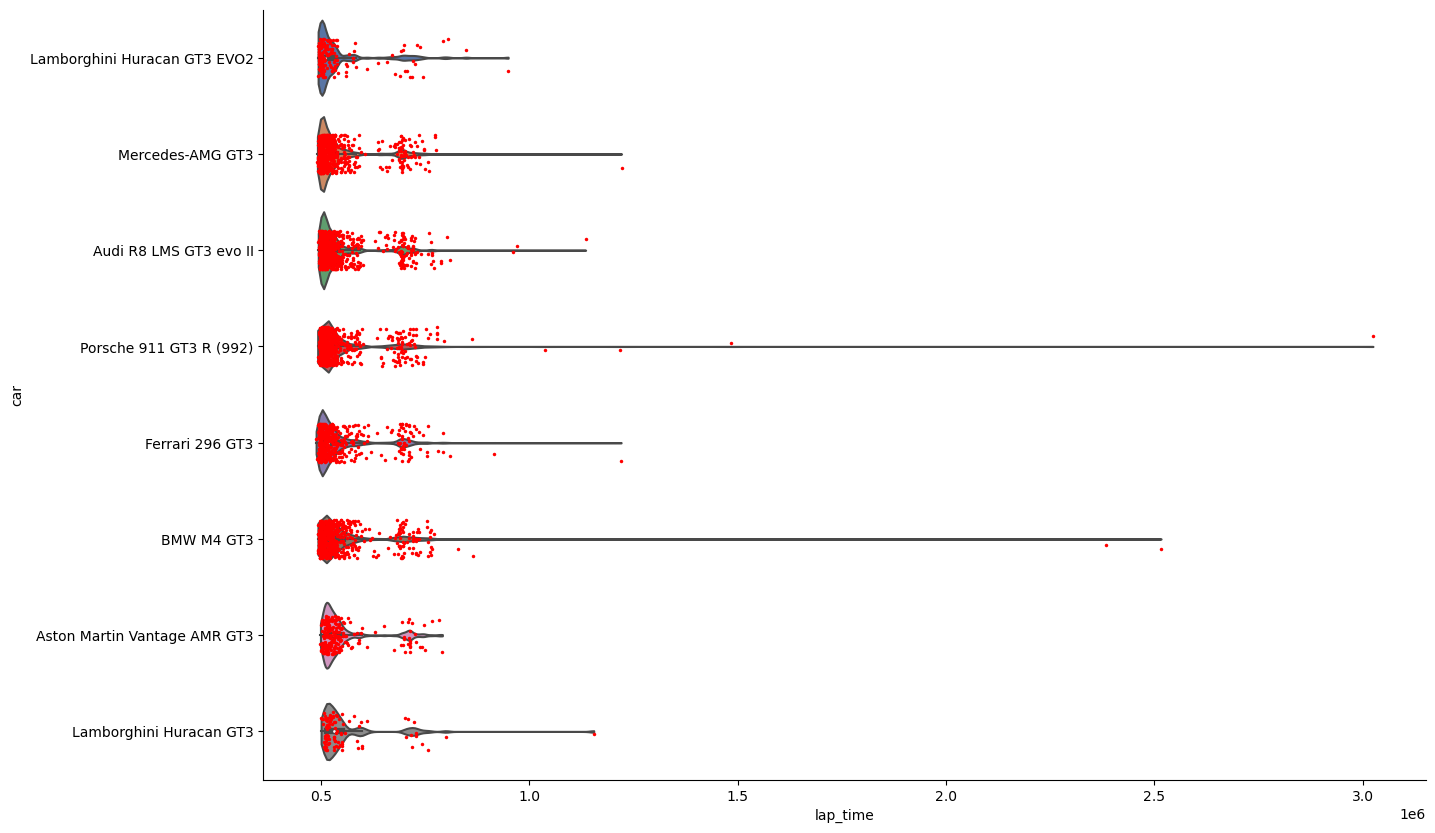

In [493]:
df_sp9_sectors = pd.DataFrame(df_race_sectors.query("class_short == 'SP 9'"))

plot_time_distribution(df_sp9_sectors)

Erster Eindruck: Einige extreme Ausreißer sorgen dafür, dass der interessante Bereich der Verteilung schwer zu erkennen ist. Wir filtern die Daten nach Rundenzeiten unter 13 Minuten:

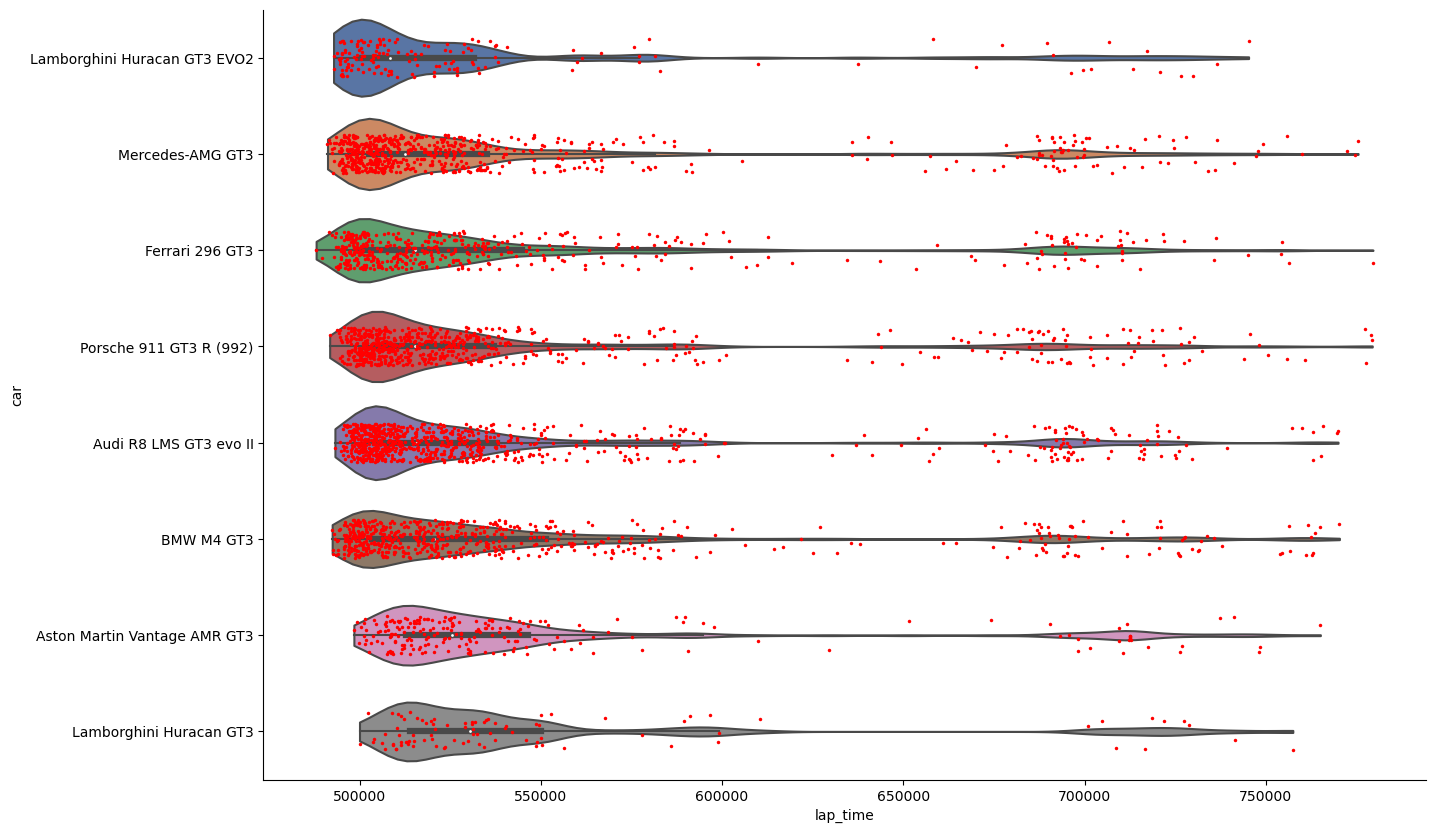

In [494]:
plot_time_distribution(df_sp9_sectors.query("lap_time < 780000"))

Auffällig ist die Q-Tip-Form. Die Rundenzeiten streuen insgesamt zwar stark, sammeln sich aber dennoch um einige Schwerpunkte.

Die Intuition aus dem Business Understanding dazu ist, dass Profifahrer:innen sehr konstante Rundenzeiten fahren können. Das bedeutet, dass die Verteilung ihrer Zeiten sich mit geringer Varianz um einen Mittelwert bewegen und nach dem zentralen Grenzwertsatz durch eine Gauß-Verteilung annäherbar sein sollte. Allerdings gilt das nur für ungestörte Runden. 

Werfen wir einen kurzen Blick auf mögliche Störgrößen:

<div style="font-size:50%;">
    <span style="width: 15%; display: inline-block;">
        <img src="img/musa-haef-traffic-unsplash.jpg" style="padding-bottom:0.2em" />
        <figcaption>Foto von Musa Haef auf Unsplash</figcaption>
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/Auto_Racing_Yellow.svg" style="padding-bottom:0.2em;" />
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/Auto_Racing_Code_60_flag.svg" style="padding-bottom:0.2em;" />
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/david-latorre-romero-pit-stop-unsplash.jpg" style="padding-bottom:0.2em;" />
        <figcaption>Foto von david latorre romero auf Unsplash</figcaption>
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/kenny-eliason-flat-tire-unsplash.jpg" style="padding-bottom:0.2em;" />
        <figcaption>Foto von Kenny Eliason auf Unsplash</figcaption>
    </span>
    <span style="width: 15%; display: inline-block;">
        <img src="img/saeed-gh-wet-road-unsplash.jpg" style="padding-bottom:0.2em;" />
        <figcaption>Foto von Saeed Gh auf Unsplash</figcaption>
    </span>

</div>

- __Verkehr__: Die Fahrer:innen müssen langsamere Fahrzeuge überholen
- __Gelbe Flagge__: Überholverbot bis zur Aufhebung. Die Fahrer:innen hängen im gegebenenfalls deutlich langsameren Verkehr fest
- __Doppelte gelbe Flagge__: Wie Gelb, zusätzlich mit Geschwindigkeitsbegrenzung auf 120 km/h
- __Code 60__: Wie Gelb, zusätzlich mit Geschwindigkeitsbegrenzung auf 60 km/h
- __Boxenstops__: Die Fahrer:innen steuern geplant zum Tanken, Reifenwechsel und Fahrerwechsel oder ungeplant zur Reparatur die Box an. Für Boxenstopps wird eine Mindeststandzeit vorgeschrieben
- __Defekt__: Die Fahrer:innen müssen in langsamer Fahrt zurück an die Box oder fallen endgültig aus
- __Streckenbedingungen__: Bei nasser Fahrbahn müssen die Fahrer:innen ihre Fahrweise deutlich anpassen
- __Kombinationen__ aus den genannten Störgrößen

__Doppeltgelbe__, __Code-60__-Bereiche und __geplante Boxenstops__ haben intuitiv einen konstanten, vergleichsweise großen Einfluss auf die Rundenzeiten aller betroffenen Fahrer. Sie verschieben Teile der Gaußverteilung mehr oder weniger stark nach rechts verschieben und sorgen für die Schwerpunkte im Stab der Q-Tips.

__Verkehr__ und __gelbe Flaggen__ sind dagegen eher zufällige Faktoren mit unsystematischem Einfluss, die sich in der Varianz der Verteilungen widerspiegeln.

Die __Streckenbedingungen__ waren während des Rennens 2023 außergewöhnlich konstant. Es wurde keine Rennrunde unter nassen Bedingungen gefahren.

__Defekte__ sind ein Sonderfall, da sie die Rundenzeit eines einzelnen Fahrers in der Regel dramatisch beeinflussen, aber eher "Einhörner", also seltene Einzelereignisse sind.

Wir gehen somit von der Annahme aus, dass die Rundenzeitverteilung einem Gaußschen Mischmodell folgt, d.h. dass sie sich in mehrere überlagerte Gaußverteilungen zerlegen lassen. Diese Information könnte dann zur Klassifikation der Rundenzeiten genutzt werden, um ungestörte Runden zur weiteren Analyse zu isolieren.

<div style="width:image width px; font-size:75%;">
    <img src="img/lap_time_distribution_clusters.jpg" width="width" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Grün: Ungestörte Runden. Gelb: Leichte Störung, orange: starke Störung. Rot: Boxenstops.</figcaption>
</div>

## Feature Learning

Um die Rundenzeiten der Fahrzeuge zu clustern und das Cluster den Daten hinzuzufügen, verwenden wir das `GaussianMixture`-Modell aus [scikit-learn](https://scikit-learn.org/stable/modules/mixture.html#gmm). Das Modell ist ein Unsupervised Learning-Verfahren, das mit der Anzahl der zu erwartenden Cluster initialisiert wird und dann die Parameter der Gaußverteilungen, die die Daten am besten beschreiben, lernt.

Runden mit Boxenstopp-Störung sind in den Daten entsprechend markiert, wir filtern entsprechend. Ebenso entfernen wir Runden, die mehr als 11 Minuten dauern. Diese sind in der Regel durch Defekte oder Unfälle verursacht und würden die Clusterbildung stören.

In [495]:
def gmc(df: pd.DataFrame, column: str, group_name: str) -> pd.DataFrame:
    gmc = mixture.GaussianMixture(n_components=4)
    res = pd.DataFrame(df)
    component_labels = gmc.fit_predict(res[[column]])
    component_mean_ranks = gmc.means_.flatten().argsort().argsort()
    component_ranks = np.vectorize(component_mean_ranks.take)(component_labels)
    res[f"cluster_by_{group_name}"] = component_ranks
    return res

df_sp9_sectors = df_sp9_sectors.query("in_pit == 'N' and lap_time < 660000")
df_sp9_sectors = df_sp9_sectors.groupby("car", group_keys=False).apply(gmc, "lap_time", "car_lap")
# print(df_sp9_sectors["cluster_by_car_lap"].value_counts())

for secnum in range(1, 10):
    df_sp9_sectors = df_sp9_sectors.dropna(subset=[f"sector_time_{secnum}"]).groupby("car", group_keys=False).apply(gmc, f"sector_time_{secnum}", f"car_sector_{secnum}")
    print(df_sp9_sectors[f"cluster_by_car_sector_{secnum}"].value_counts())

c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

KeyError: ['sector_time_1']

Nach dem Fitting des Modells können wir die Clusterzugehörigkeit der Runden abfragen und die Plausibilität des Clusterings anhand der Visualisierung bewerten:

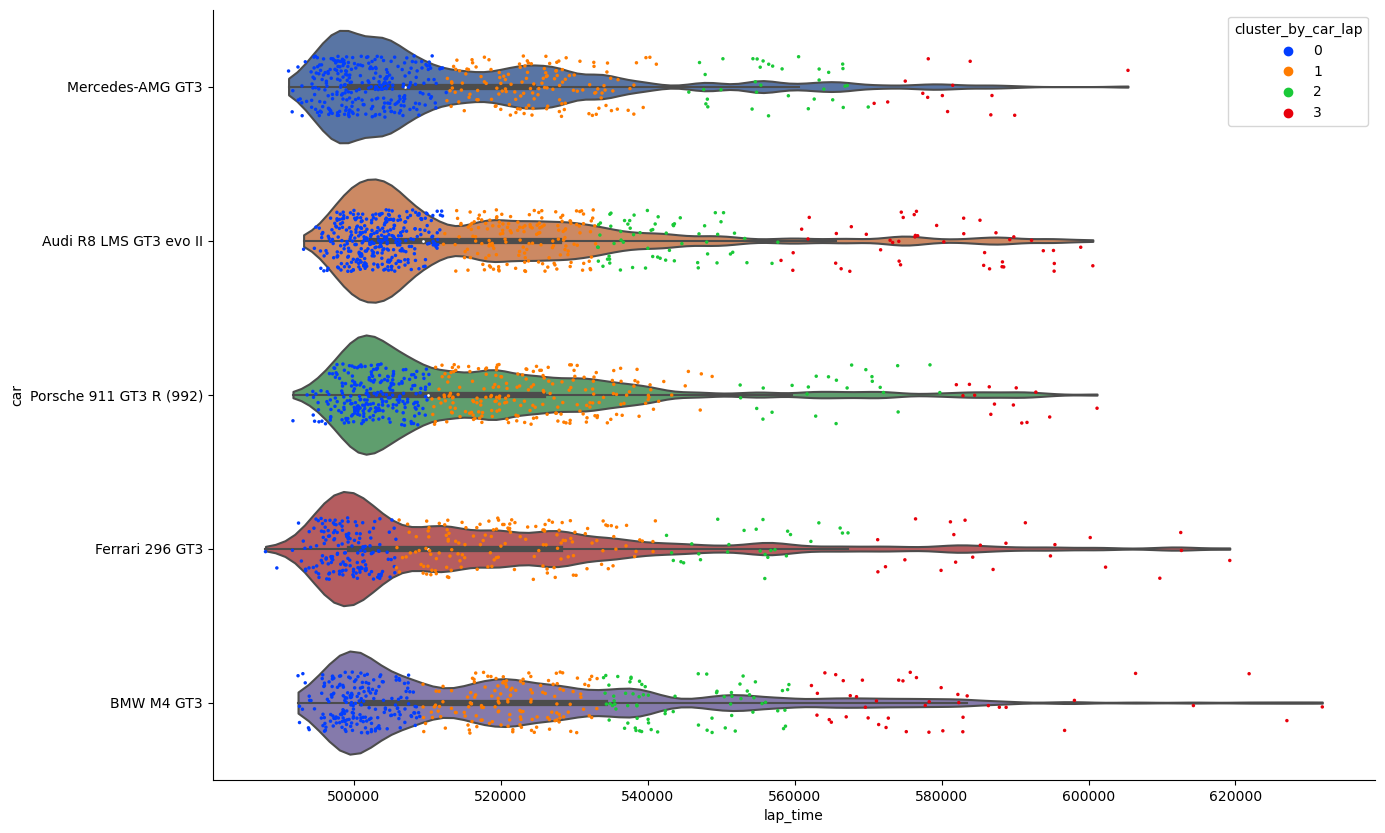

In [ ]:
plot_time_distribution(df_sp9_sectors, hue="cluster_by_car_lap")

Das Modell ist insbesondere bei den Fahrzeugen, die vergleichsweise wenige Runden gefahren sind, nicht perfekt, fängt aber die Struktur der Verteilung gut ein.

Nun können wir die Clusterinformation nutzen, um ungestörte Rundenzeiten zu selektieren und deren Verteilung für die einzelnen Fahrzeuge zu visualisieren (wir lassen die abgeschlagenen Fahrzeuge ab hier weg):

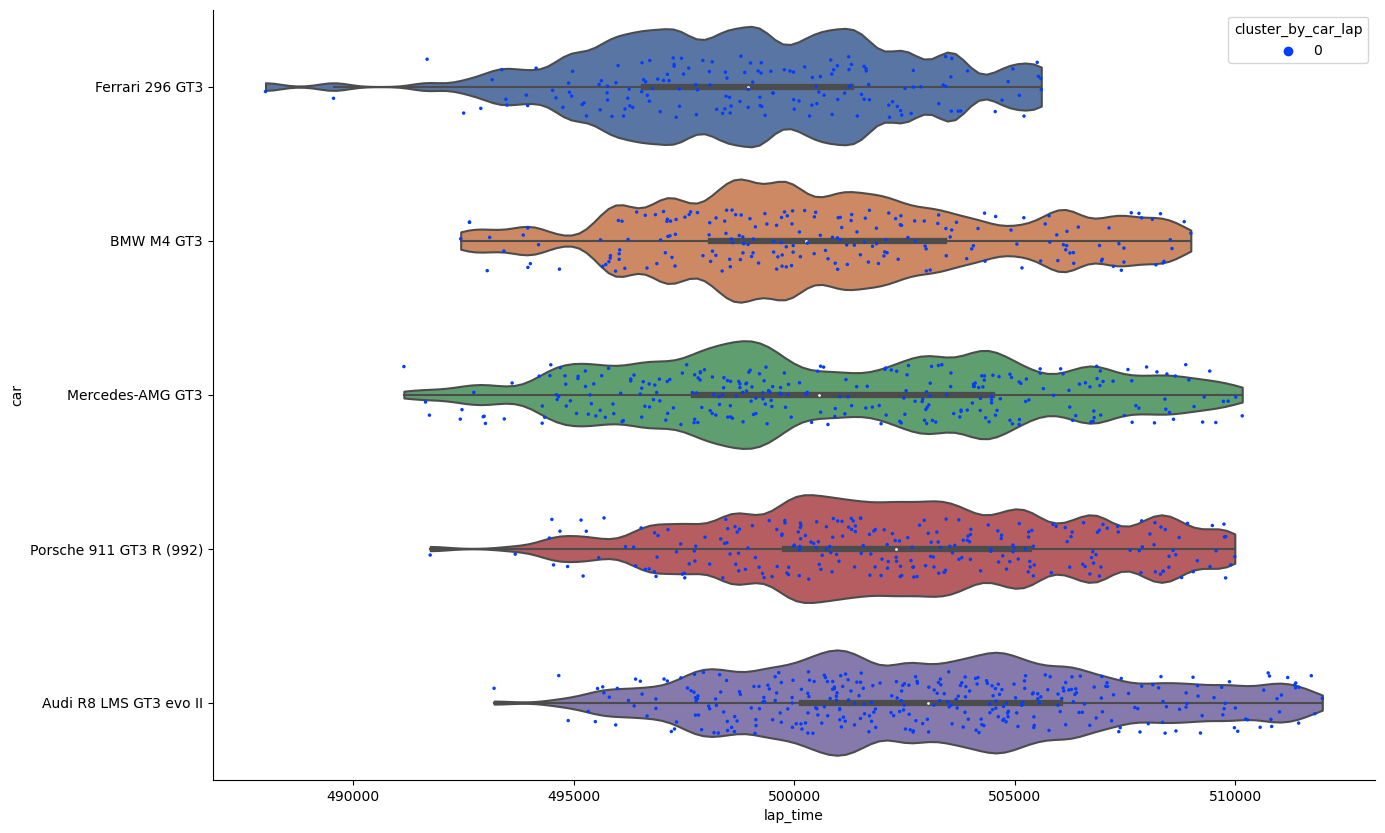

In [496]:
df_sp9_sectors = df_sp9_sectors.query("car != ['Lamborghini Huracan GT3', 'Lamborghini Huracan GT3 EVO2', 'Aston Martin Vantage AMR GT3']")
df_clean_laps = pd.DataFrame(df_sp9_sectors.query("cluster_by_car_lap == 0"))
plot_time_distribution(df_clean_laps, hue="cluster_by_car_lap")

Tatsächlich zeigt sich für den 296 GT3 eine etwas bessere Rundenzeitverteilung als für die restlichen Fahrzeuge. Wir vergleichen abschließend die Sektorzeiten in schnellen Runden zwischen Ferraris und anderen Fabrikaten (in Leserichtung, Sektor 1 links oben):

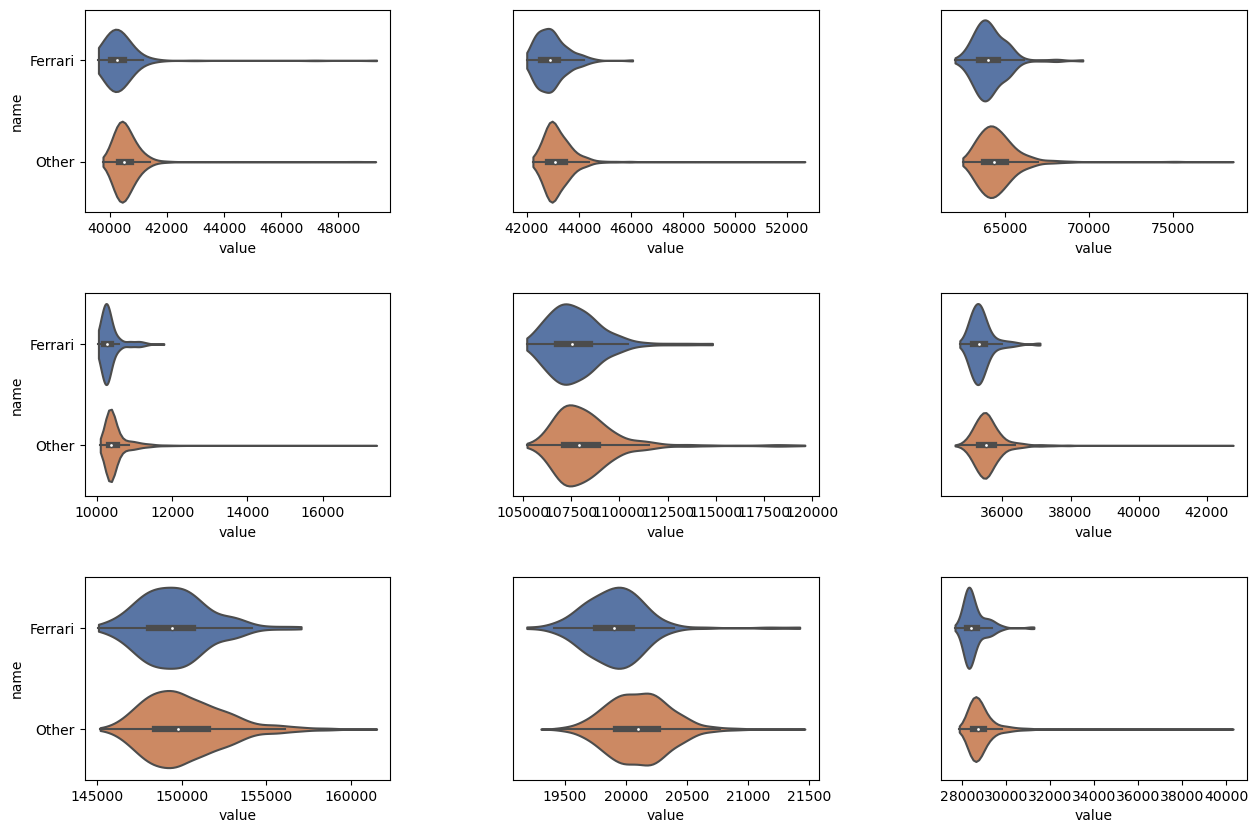

In [576]:
from itertools import chain


def get_sector_times(df: pd.DataFrame) -> pd.DataFrame:
    columns = [[f"sectortime_{i}"] for i in range(1, 10)]
    columns = [*columns, ["lap_time"]]
    columns = list(chain.from_iterable(columns))
    dfst = df.loc[:, columns]
    dfst.columns = pd.MultiIndex.from_tuples(
        [tuple(c.split("_")) for c in dfst.columns]
    )
    return dfst


def plot_sectors(df: pd.DataFrame) -> None:
    df = df.copy()
    
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1, 10):
        df_sub = df.query(f"variable_1 == '{i}'")
        ax = fig.add_subplot(3, 3, i)
        sns.violinplot(
            data=df_sub,
            y="name",
            # split=True,
            x="value",
            palette="deep",
            cut=0,
            showfliers=False,
            ax=ax,
        )
        if i % 3 != 1:
            ax.set(yticklabels=[]) # remove axis info
            ax.set(ylabel=None)  
            ax.tick_params(left=False)
    plt.show()


df_ferrari_sectors = (
    get_sector_times(df_clean_laps.query("car == 'Ferrari 296 GT3'"))
    .melt()
    .query("variable_0 == 'sectortime'")
)
df_ferrari_sectors["is_ferrari"] = True
df_ferrari_sectors["name"] = "Ferrari"
df_unferrari_sectors = (
    get_sector_times(df_clean_laps.query("car != 'Ferrari 296 GT3'"))
    .melt()
    .query("variable_0 == 'sectortime'")
)
df_unferrari_sectors["is_ferrari"] = False
df_unferrari_sectors["name"] = "Other"

df_all_sectors = pd.concat([df_ferrari_sectors, df_unferrari_sectors])

plot_sectors(df_all_sectors)

Auch hier zeigt sich ein leichter Vorteil für den 296 GT3. Insbesondere in den Sektoren 8 und 9 macht sich der Unterschied bemerkbar:

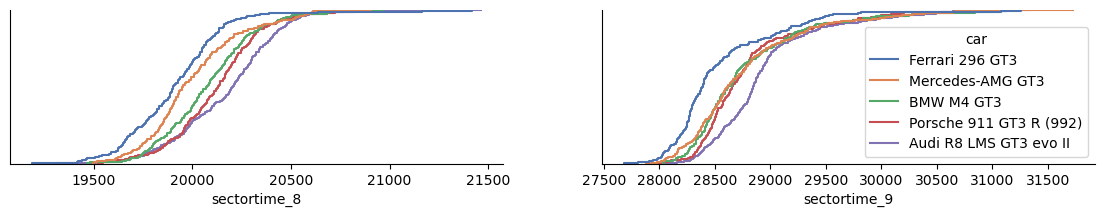

In [578]:
def plot_time_ridge(df: pd.DataFrame, values: list[str] = ["lap_time"], hue: str | None = None) -> None:
    df = df.copy()
    f, ax = plt.subplots(ncols=len(values), figsize=(14, 2))

    for i, value in enumerate(values):
        df["__sort_q2"] = df.groupby("car")[value].transform(np.quantile, q=0.5)    
        df.sort_values("__sort_q2", inplace=True)
    
        p = sns.ecdfplot(
            hue=df["car"],
            x=df[value],
            # kind="kde",
            # bw=0.1,
            # bw_method="silverman",
            # width=1.5,
            palette="deep",
            ax=ax[i],
            legend=False if i==0 else True
        )
        p.set(yticklabels=[])  # remove the tick labels
        p.set(ylabel=None)  # remove the axis label
        p.tick_params(left=False)
    sns.despine()

plot_time_ridge(df_clean_laps.query("cluster_by_car_lap == 0 and sectortime_9 < 32000"), values=["sectortime_8", "sectortime_9"])

Ein Blick auf die Streckenkarte zeigt, dass die Sektoren 8 und 9 zur langen Geraden vor Start und Ziel gehören:

In [583]:
from dataclasses import dataclass


@dataclass
class Coords:
    lat: float
    lon: float


map_center = Coords(
    50.628615,
    6.883192,
)
track_center = Coords(50.35849, 6.95916)

tiles = "CartoDB Dark_Matter" if _DARK_MODE else "CartoDB positron"

nbr_map = folium.Map(
    location=[track_center.lat, track_center.lon],
    zoom_start=13,
    tiles=tiles,
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
    scrollWheelZoom=False,
)
# folium.FitBounds([50.195944, 6.835599], [50.990013, 7.125149]).add_to(nbr_map)

folium.Marker(
    [track_center.lat, track_center.lon], popup="Nürburgring track center"
).add_to(nbr_map)

# create a color palette with 9 distinct colors
colors = sns.color_palette("Paired", n_colors=9).as_hex()


def style_function(x: dict) -> dict[str, str]:
    """
    Returns a style dictionary that assigns a specific color based on the last character of the
    'name' property in the input dictionary.

    Args:
        x (dict): A dictionary which contains a 'properties' dictionary,
                  which in turn contains a 'name' attribute. The 'name' attribute is assumed
                  to be a string ending with a numeric character (1-9).

    Returns:
        dict[str, str]: A style dictionary where 'color' is the key and the corresponding
                        color from the palette is the value.
    """

    # gets the last character from 'name' in 'properties' of dictionary 'x', converts it to an integer,
    # subtracts one to use as an index, and gets the corresponding color from the color palette.
    return {"color": colors[int(x["properties"]["name"][-1]) - 1]}


for i in range(9):
    folium.GeoJson(
        f"data/gis/NBR 24h S{i+1}.geojson",
        style_function=style_function,
        tooltip=f"Sector {i+1}",
    ).add_to(nbr_map)

# folium.GeoJson(f"data/gis/frankenbad-agrippinawerft.geojson").add_to(nbr_map)

nbr_map

<Axes: xlabel='lap_time', ylabel='Proportion'>

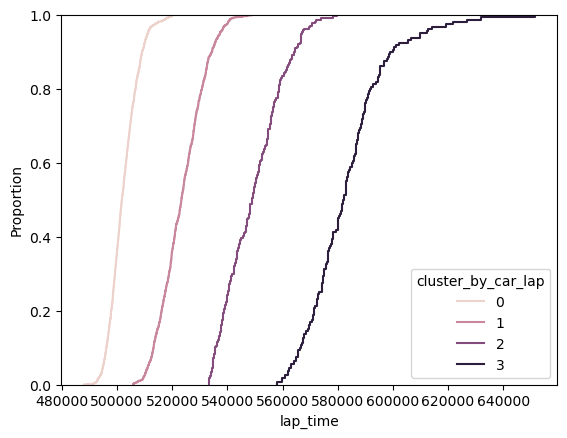

In [433]:
# f, ax = plt.subplots(figsize=(15, 10))
sns.ecdfplot(
    df_sp9_sectors,
    x="lap_time",
    hue="cluster_by_car_lap",
    # kind="kde",
    log_scale=(False, False),
)

In [305]:
df_race_sectors.groupby("car_number").min().sort_values("theoretical_best_time").loc[:, ["team", "car", "time_of_day", "theoretical_best_time"]].head(10)

,team,car,time_of_day,theoretical_best_time
car_number,,,,
20,WTM by Rinaldi Racing,Ferrari 296 GT3,00:02:03.432,485552
30,Frikadelli Racing Team,Ferrari 296 GT3,00:08:13.926,486623
4,Mercedes-AMG Team Bilstein,Mercedes-AMG GT3,00:02:24.700,487109
98,ROWE RACING,BMW M4 GT3,00:01:12.252,487212
2,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,00:10:28.985,487900
27,ABT Sportsline,Lamborghini Huracan GT3 EVO2,00:05:33.990,488351
911,Manthey EMA,Porsche 911 GT3 R (992),00:07:58.487,489081
99,ROWE RACING,BMW M4 GT3,00:11:00.028,489356
72,BMW Junior Team,BMW M4 GT3,00:10:38.355,490034


# Data Preparation

> - Datenbereinigung und Transformationen
> - Datenverknüpfung und -aggregation
> - Feature Engineering
> - Feature Selection
> - Preprocessing
> - Normierung z.B. von Preisen, Skalierung Bereichen
> - Bereinigung
> - Transformation

## Datenverknüpfung

### Sonnenstand

Um Einflüsse durch den Sonnenstand, insbesondere durch Blendung bewerten zu können, bestimmen den Azimut und die Höhe der Sonne für jede Runde mit dem [suncalc](https://github.com/kylebarron/suncalc-py)-Paket von Kyle Barron. Wir berechnen die Position der Sonne relativ zu einem willkürlich gewählten Punkt nahe dem Zentrum der Strecke (50°21'30.6"N 6°57'33.0"E) zum Zeitpunkt jeder abgeschlossenen Runde. Wir verwenden dazu nicht den Wert `time_of_day`, da dieser kein Datum enthält und wir den Übergang vom Samstag zum Sonntag gesondert behandeln müssten. Besser eignet sich der `time_elapsed`-Wert - die seit dem 20.05.2023 um 00:00:00+02:00 zum Abschluss jeder Runde verstrichene Zeit in Millisekunden:

### Wetter

Wir fügen Wetterdaten hinzu, um die Rundenzeiten in Abhängigkeit von den Wetterbedingungen analysieren zu können. Wir beziehen die Wetterdaten vom [Deutschen Wetterdienst (DWD)](https://www.dwd.de/EN/Home/home_node.html), der aktuelle und historische Stationsdaten im CSV-Format zur Verfügung stellt. Wir nutzen die Lufttemperatur in 2 Metern Höhe (OBS_DEU_PT10M_T2M) und den Luftdruck auf Stationsniveau (OBS_DEU_PT10M_PP), die [an der Station Nürburg-Barweiler](https://cdc.dwd.de/portal/shortlink/c2acc37b-bd80-4c5c-b78b-1335d3f19c20) in 10-Minuten-Intervallen gemessen wurden (etwa 6,34 km vom Referenzpunkt entfernt).

Spaßiges Problem: Die CSV des DWD haben ein zusätzliches abschließendes Trennzeichen pro Zeile, was dazu führt, dass der Pandas-CSV-Parser die erste Spalte als Zeilenindex des DataFrames behandelt und die restlichen Daten sich ein Feld nach links schieben. Um dies zu beheben, übergeben wir `index_col=False` an `pd.read_csv()`.

Wir stellen sicher, dass die Zeitstempel auf die gleiche Zeitzone wie die Rundenzeiten gesetzt sind und indizieren die Wetterdaten nach Zeitstempel, um das Zusammenführen zu erleichtern. 

Wir verknüpfen die gesammelten Wetterdaten mit unseren Rundenzeiten. Da die Zeitstempel der Wettermessungen nicht mit den Durchgangszeiten synchronisiert sind, führen wir einen __Merge nach Schlüsseldistanz__ durch und fügen jeder Runde den zeitlich nächsten Messwert hinzu:


## Preprocessing

## Bereinigung

Mit Hilfe der im Feature Learning identifizierten Cluster können wir nun ungestörte Runden zur weiteren Analyse selektieren.

## Transformation


# Modeling

> - Definition der Annahmen und Rahmenbedingungen der Modellierung 
> - Auswahl von geeigneten Algorithmen 
> - Test Design 
> - Training des Modells 
> - Tiefgreifende, zielgerichtete Datenexploration
> - z.B. Reinforcement, Supervised, Unsupervised Learning
> - Wenn der Datensatz sehr komplex ist, ist es nicht zwingend notwendig eine Modellierung zu machen. Wenn beispielsweise fehlende Daten aufgrund des Business Case nicht rausgeschmissen werden dürfen, dass man die Verteilung analysiert oder schaut wie man die fehlenden Daten ggf. ersetzen kann (würde es aber mit ihm absprechen ab wann ein Datensatz für ihn komplex genug ist, um auf Modelling zu verzichten)

Unsupervised Learning:
- Gaussian Mixture Model
- K-Means
- Evaluation durch Visualisierung
- Wenn möglich, Evaluation mit Silhouette Score

# Evaluation

> - Vergleich der verschiedenen Modelle anhand von Gütekriterien 
> - Betrachtung der Interpretierbarkeit des Modells
> - Kritische Analyse des Modellierungsprozesses
> - Abgleich mit (wirtschaftlichen) Erfolgskriterien 
> - Definition von Folgeaktivitäten
> - Kritisch hinterfragen
> - Ausblick

## Kritische Würdigung

- Aufwand für Data Wrangling deutlich unterschätzt - um die Daten in eine Form zu bringen, die für die Analyse geeignet ist, war jede Menge Boilerplate-Code nötig
- Datensatz so umfangreich und komplex, dass ich ihn nicht in der Tiefe analysieren konnte, die ich mir vorgenommen hatte
- Key Learning: In großen Datensätzen kann man sich verlaufen und sich in Details und Nebensächlichkeiten verlieren
- Das Clustering per GaussianMixture ist nicht sonderlich robust und hat relativ viel manuelles Tuning erfordert
  - Die "richtige" Anzahl der Cluster ist nicht vorab bestimmbar, sondern muss iterativ ermittelt werden
  - Grid Search könnte hier evtl. helfen, aber dazu wäre ein Score nötig, der die Qualität der Cluster misst (z.B. Silhouette Score)
- Die Wetterbedingungen waren 2023 außergewöhnlich konstant, es war insbesondere immer trocken

## Ausblick

- Weitere/andere Verfahren zur Anomalieerkennung
- Mehr Daten (Training, Qualifying, weitere Rennen, weitere Strecken)
- Mehr Features (Lufttemperatur, Luftdruck, Sonnenstand, Streckentemperatur, Fahrerbewertung) 
- Semisupervised Learning



# Backup ab hier

In [288]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

df_stint = df_sp9_sectors.reset_index().loc[:, ["cluster_by_car_lap", "car_number", "lap_time"]]
df_stint_train, df_stint_test = train_test_split(df_stint, test_size=0.2)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
params = {'n_estimators': [25, 50, 100, 200],
          'criterion':    ['friedman_mse'],
          'max_depth':    [2, 4, 6, 8, 10]}
k      = 3

model_cv = GridSearchCV(model, params, cv = k)
model_cv.fit(df_stint_train.loc[:, ["car_number", "lap_time"]], df_stint_train["cluster_by_car_lap"])

print(model_cv.score(df_stint_test.loc[:, ["car_number", "lap_time"]], df_stint_test["cluster_by_car_lap"]))

0.971708435923792


## Import and cleaning

In [64]:
df_race_sectors  = read_sector_times([
        "data/2023/24h/race_rennen_sektorzeiten_part_1.csv",
        "data/2023/24h/race_rennen_sektorzeiten_part_2.csv",
    ])
df_race_sectors.groupby("car_number").min().sort_values("theoretical_best_time").loc[:, ["team", "car", "time_of_day", "theoretical_best_time"]].head(5)

,team,car,time_of_day,theoretical_best_time
car_number,,,,
20,WTM by Rinaldi Racing,Ferrari 296 GT3,00:02:03.432,485552
30,Frikadelli Racing Team,Ferrari 296 GT3,00:08:13.926,486623
4,Mercedes-AMG Team Bilstein,Mercedes-AMG GT3,00:02:24.700,487109
98,ROWE RACING,BMW M4 GT3,00:01:12.252,487212
2,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,00:10:28.985,487900


### Incorporating Solar Information

In this step, we determine the azimuth and altitude of the sun for each lap, utilizing Kyle Barron's [suncalc](https://github.com/kylebarron/suncalc-py) package. The sun's position is calculated relative to an arbitrarily chosen point near the center of the track (50°21'30.6"N 6°57'33.0"E) at the time each lap was executed.

To ascertain the exact time each lap took place, one might initially consider using the `time_of_day` parameter. However, this metric presents ambiguities as it lacks date-specific details and complications arise due to the transition from one day to the next during the course of the race. As a result, we opt to employ the `time_elapsed` parameter instead. This represents the duration in milliseconds elapsed since 2023-05-20 00:00:00+02:00, marked at the completion of each lap.

In [8]:
from dataclasses import dataclass


@dataclass
class Coords:
    lat: float
    lon: float


map_center = Coords(
    50.628615,
    6.883192,
)
track_center = Coords(50.35849, 6.95916)
bonn_frankenbad = Coords(50.73968, 7.087501)
köln_agrippinawerft = Coords(50.921823, 6.967961)

tiles = "CartoDB Dark_Matter" if _DARK_MODE else "CartoDB positron"

nbr_map = folium.Map(
    location=[map_center.lat, map_center.lon],
    zoom_start=10,
    tiles=tiles,
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
    scrollWheelZoom=False,
)
# folium.FitBounds([50.195944, 6.835599], [50.990013, 7.125149]).add_to(nbr_map)

folium.Marker(
    [track_center.lat, track_center.lon], popup="Nürburgring track center"
).add_to(nbr_map)
folium.Marker(
    [bonn_frankenbad.lat, bonn_frankenbad.lon],
    popup="Bonn Frankenbad",
    icon=folium.Icon(color="green"),
).add_to(nbr_map)
folium.Marker(
    [köln_agrippinawerft.lat, köln_agrippinawerft.lon],
    popup="Köln Agrippinawerft",
    icon=folium.Icon(color="red"),
).add_to(nbr_map)

# create a color palette with 9 distinct colors
colors = sns.color_palette("Paired", n_colors=9).as_hex()


def style_function(x: dict) -> dict[str, str]:
    """
    Returns a style dictionary that assigns a specific color based on the last character of the
    'name' property in the input dictionary.

    Args:
        x (dict): A dictionary which contains a 'properties' dictionary,
                  which in turn contains a 'name' attribute. The 'name' attribute is assumed
                  to be a string ending with a numeric character (1-9).

    Returns:
        dict[str, str]: A style dictionary where 'color' is the key and the corresponding
                        color from the palette is the value.
    """

    # gets the last character from 'name' in 'properties' of dictionary 'x', converts it to an integer,
    # subtracts one to use as an index, and gets the corresponding color from the color palette.
    return {"color": colors[int(x["properties"]["name"][-1]) - 1]}


for i in range(9):
    folium.GeoJson(
        f"data/gis/NBR 24h S{i+1}.geojson",
        style_function=style_function,
        tooltip=f"Sector {i+1}",
    ).add_to(nbr_map)

folium.GeoJson(f"data/gis/frankenbad-agrippinawerft.geojson").add_to(nbr_map)

nbr_map

With the elevation of the sun established for each lap, we are now equipped to distinguish the laps undertaken during nighttime hours. Adhering to the civil twilight threshold designated by the [European Union Aviation Safety Agency](http://www.easa.europa.eu/),  we'll consider a lap to be performed "under dark conditions" if the sun's elevation is below -6° [@EuropeanCommission_Regulation9232012_2012, art 2]. Suncalc returns the sun's elevation in radians, so we need to convert the threshold value: $-\frac{6}{180}\pi \approx -0,10472$

In [306]:
import math

elapsed_zero = pd.Timestamp("2023-05-20 00:00:00", tz="Europe/Berlin").tz_convert("utc")
df_sp9_sectors["lap_timestamp"] = elapsed_zero + df_sp9_sectors[
    "elapsed_time"
].astype("timedelta64[ms]")

solar_positions = pd.DataFrame(
    suncalc.get_position(
        df_sp9_sectors["lap_timestamp"], track_center.lon, track_center.lat
    )
)

df_sp9_sectors = pd.concat([df_sp9_sectors, solar_positions], axis=1)

night_threshold = -6 / 180 * math.pi
df_sp9_sectors["night"] = df_sp9_sectors["altitude"] < (night_threshold)

glare_lower_threshold = -1 / 180 * math.pi
glare_upper_threshold = 15 / 180 * math.pi
df_sp9_sectors["glare"] = df_sp9_sectors["altitude"].apply(
    lambda x: glare_lower_threshold < x < glare_upper_threshold
)

df_sp9_sectors.sample(5).loc[:, ["lap_timestamp", "night", "glare"]]

lap_timestamp  night  glare
car_number lap_number                                               
10         12         2023-05-20 15:44:24.947000+00:00  False  False
           20         2023-05-20 16:56:39.529000+00:00  False  False
69         46         2023-05-20 21:01:32.701000+00:00   True  False
22         59         2023-05-20 22:47:37.564000+00:00   True  False
39         74         2023-05-21 01:08:19.484000+00:00   True  False

### Incorporating Weather Information

We obtain weather data from the [Deutscher Wetterdienst](https://www.dwd.de/EN/Home/home_node.html) (DWD), who provide current and historical station data in CSV format. We utilize the air temperature at 2 meters height (OBS_DEU_PT10M_T2M) and the air pressure at station level (OBS_DEU_PT10M_PP), which were [measured at the Nürburg-Barweiler station](https://cdc.dwd.de/portal/shortlink/c2acc37b-bd80-4c5c-b78b-1335d3f19c20) (approximately 6.34 km away from the reference point) at 10-minute intervals.

While the DWD provides the data in UTC, the time stamps are not aligned with the lap times. To remedy this, we interpolate the weather data to obtain values at the exact time each lap was completed. We then add the temperature and air pressure for each lap to our dataframe.

Fun problem: The DWD CSVs have an extra trailing delimiter per line, which [makes pandas CSV parser treat the first column as the DataFrame's row names](https://wesmckinney.com/blog/update-on-upcoming-pandas-v0-10-new-file-parser-other-performance-wins/). To remedy this, we pass `index_col=False` to `pd.read_csv()`.

We index the weather data by timestamp to facilitate merging. We also make sure the timestamps are set to the same timezone as the lap times, so that we can merge the dataframes without having to worry about timezones.

In [307]:
def read_weather_data(filename: str) -> pd.DataFrame:
    weather_data = pd.read_csv(
        filename,
        sep=",",
        index_col=False,
        usecols=["Zeitstempel", "Wert"],
        # parse_dates=["Zeitstempel"],
    )
    weather_data["Zeitstempel"] = pd.to_datetime(weather_data["Zeitstempel"], utc=True)
    weather_data.set_index("Zeitstempel", inplace=True)
    return weather_data

air_temp_df = read_weather_data("data/weather/data_OBS_DEU_PT10M_T2M_3660.csv")
air_temp_df.rename(columns={"Wert": "air_temperature"}, inplace=True)
air_pressure_df = read_weather_data("data/weather/data_OBS_DEU_PT10M_PP_3660.csv")
air_pressure_df.rename(columns={"Wert": "air_pressure"}, inplace=True)

atm_df = pd.merge(
    air_temp_df,
    air_pressure_df,
    left_index=True,
    right_index=True,
)

atm_df.sample(5)

,air_temperature,air_pressure
Zeitstempel,,
2023-05-20 06:40:00+00:00,10.1,962.9
2023-05-22 00:10:00+00:00,14.8,957.9
2023-05-22 23:50:00+00:00,13.0,960.5
2023-05-21 11:50:00+00:00,19.9,958.0
2023-05-20 17:50:00+00:00,14.1,961.1


We perform a [merge by key distance](https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html).

In [308]:
# Both dataframes must be sorted by timestamp
df_sp9_sectors.sort_values(by="lap_timestamp", inplace=True)
atm_df.sort_index(inplace=True)

df_sp9_sectors = pd.merge_asof(
    df_sp9_sectors,
    atm_df,
    left_on="lap_timestamp",
    right_index=True,
    direction="nearest",
)

df_sp9_sectors.sample(5).loc[:, ["lap_timestamp", "air_temperature", "air_pressure"]]

,,lap_timestamp,air_temperature,air_pressure
car_number,lap_number,,,
100,57,2023-05-20 22:55:00.350000+00:00,10.4,960.2
11,17,2023-05-20 16:29:23.631000+00:00,15.3,960.8
5,8,2023-05-20 15:09:34.849000+00:00,15.8,960.6
10,17,2023-05-20 16:30:44.979000+00:00,15.3,960.8
30,108,2023-05-21 06:10:31.795000+00:00,10.8,958.7


## Analyse

Add a timestamp for the completion of each sector

In [12]:
df_race_sectors

,,team,car,elapsed_time,time_of_day,lap_time,class_short,sector_time_1,sector_is_best_time_1,sector_time_2,sector_is_best_time_2,...,lap_in_stint,theoretical_best_time,driver_name,lap_timestamp,azimuth,altitude,night,glare,air_temperature,air_pressure
car_number,lap_number,,,,,,,,,,,,,,,,,,,,,
4,1,Mercedes-AMG Team Bilstein,Mercedes-AMG GT3,58108614,16:08:28.614,504275,SP 9,46331.0,False,43376.0,False,...,1,487109,"Marciello, Raffaele",2023-05-20 14:08:28.614000+00:00,1.058958,0.807892,False,False,17.2,960.6
27,1,ABT Sportsline,Lamborghini Huracan GT3 EVO2,58109489,16:08:29.489,505150,SP 9,47032.0,False,43342.0,False,...,1,488351,"Mapelli, Marco",2023-05-20 14:08:29.489000+00:00,1.059028,0.807856,False,False,17.2,960.6
30,1,Frikadelli Racing Team,Ferrari 296 GT3,58109943,16:08:29.943,505604,SP 9,47200.0,False,43513.0,False,...,1,486623,"Pittard, David",2023-05-20 14:08:29.943000+00:00,1.059064,0.807838,False,False,17.2,960.6
3,1,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,58110437,16:08:30.437,506098,SP 9,47503.0,False,43783.0,False,...,1,490862,"Engel, Maro",2023-05-20 14:08:30.437000+00:00,1.059103,0.807818,False,False,17.2,960.6
44,1,Falken Motorsports,Porsche 911 GT3 R (992),58111046,16:08:31.046,506707,SP 9,47773.0,False,43892.0,False,...,1,490957,"Menzel, Nico",2023-05-20 14:08:31.046000+00:00,1.059152,0.807793,False,False,17.2,960.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,144,Teichmann Racing,Toyota GR Supra GT4 EVO 2023,144972265,16:16:12.265,621353,SP 10,44849.0,False,49398.0,False,...,6,535316,"Naumann, Florian",2023-05-21 14:16:12.265000+00:00,1.098239,0.791992,False,False,20.6,957.9
68,74,Dörr Motorsport,Aston Martin Vantage AMR GT4,145007690,16:16:47.690,652176,SP 10,46452.0,False,50105.0,False,...,5,544401,"Hoppelshäuser, Olaf",2023-05-21 14:16:47.690000+00:00,1.100978,0.790529,False,False,20.6,957.9
108,84,sharky-racing by MSC Sinzig e.V. im ADAC,VW GOLF GTI TCR DSG*,145058254,16:17:38.254,753797,SP 3T,51751.0,False,55465.0,False,...,3,576521,"Jodexnis, Richard",2023-05-21 14:17:38.254000+00:00,1.104878,0.788437,False,False,20.6,957.9


In [13]:
df_race_sectors["sector_timestamp_9"] = df_race_sectors["lap_timestamp"]
df_race_sectors["sector_timestamp_8"] = df_race_sectors[
    "lap_timestamp"
] - df_race_sectors["sector_time_9"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_7"] = df_race_sectors[
    "sector_timestamp_8"
] - df_race_sectors["sector_time_7"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_6"] = df_race_sectors[
    "sector_timestamp_7"
] - df_race_sectors["sector_time_6"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_5"] = df_race_sectors[
    "sector_timestamp_6"
] - df_race_sectors["sector_time_5"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_4"] = df_race_sectors[
    "sector_timestamp_5"
] - df_race_sectors["sector_time_4"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_3"] = df_race_sectors[
    "sector_timestamp_4"
] - df_race_sectors["sector_time_3"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_2"] = df_race_sectors[
    "sector_timestamp_3"
] - df_race_sectors["sector_time_2"].astype("timedelta64[ms]")
df_race_sectors["sector_timestamp_1"] = df_race_sectors[
    "sector_timestamp_2"
] - df_race_sectors["sector_time_1"].astype("timedelta64[ms]")
df_race_sectors.reset_index()

df_long_sectors = pd.wide_to_long(
    df_race_sectors.reset_index(),
    stubnames=["sector_time", "sector_timestamp"],
    i=["car_number", "lap_number"],
    j="sector",
    sep="_",
    # suffix="\w+",
).reset_index()


In [14]:


df_melted = pd.concat([
    pd.melt(
        df_race_sectors,
        id_vars=[
            "elapsed_time",
            "lap_timestamp",
            "night",
            "glare",
            "air_temperature",
            "air_pressure",
            f"sector{secnum}_timestamp",
        ],
        value_vars=[
            f"sector{secnum}_time",
        ],
    ) for secnum in range(1, 10)
])
    

df_long = pd.melt(
    df_race_sectors,
    id_vars=[
        "elapsed_time",
        "lap_timestamp",
        "night",
        "glare",
        "air_temperature",
        "air_pressure",
        
    ],
    value_vars=[
        "sector1_time",
        "sector2_time",
        "sector3_time",
        "sector4_time",
        "sector5_time",
        "sector6_time",
        "sector7_time",
        "sector8_time",
        "sector9_time",
        "sector1_timestamp",
        "sector2_timestamp",
        "sector3_timestamp",
        "sector4_timestamp",
        "sector5_timestamp",
        "sector6_timestamp",
        "sector7_timestamp",
        "sector8_timestamp",
    ],
)
df_long.sample(5)

# df_long.where(df_long["variable"].str.endswith("time")).dropna().sample(5)
# df_melted

KeyError: "The following 'id_vars' are not present in the DataFrame: ['sector1_timestamp']"

In [ ]:
df_timestamps = df_race_sectors.loc[:, [
        "sector1_timestamp",
        "sector1_time",
        "sector2_timestamp",
        "sector2_time",
        "sector3_timestamp",
        "sector3_time",
        "sector4_timestamp",
        "sector4_time",
        "sector5_timestamp",
        "sector5_time",
        "sector6_timestamp",
        "sector6_time",
        "sector7_timestamp",
        "sector7_time",
        "sector8_timestamp",
        "sector8_time",
        "sector9_timestamp",
        "sector9_time"]] 
df_timestamps.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) for c in df_timestamps.columns])
df_timestamps.sample(5)
# df_timestamps.melt(value_name="time", id_vars=[("sector1", "timestamp"), ("sector1", "time")])

sector1           \
                                             timestamp     time   
car_number lap_number                                             
243        103        2023-05-21 08:11:15.314000+00:00  47362.0   
241        85         2023-05-21 05:17:42.156000+00:00  49110.0   
66         70                                      NaT  45838.0   
185        98         2023-05-21 09:40:49.171000+00:00  46803.0   
120        122        2023-05-21 13:27:09.001000+00:00  49495.0   

                                               sector2           \
                                             timestamp     time   
car_number lap_number                                             
243        103        2023-05-21 08:12:02.676000+00:00  51333.0   
241        85         2023-05-21 05:18:31.266000+00:00  52093.0   
66         70                                      NaT  47620.0   
185        98         2023-05-21 09:41:35.974000+00:00  50510.0   
120        122        2023-05-21 13:27:58.496000+00:00  53669.0   

                                               sector3           \
                                             timestamp     time   
car_number lap_number                                             
243        103        2023-05-21 08:12:54.009000+00:00  76391.0   
241        85         2023-05-21 05:19:23.359000+00:00  82226.0   
66         70                                      NaT  71557.0   
185        98         2023-05-21 09:42:26.484000+00:00  73851.0   
120        122        2023-05-21 13:28:52.165000+00:00  79769.0   

                                               sector4           \
                                             timestamp     time   
car_number lap_number                                             
243        103        2023-05-21 08:14:10.400000+00:00  12116.0   
241        85         2023-05-21 05:20:45.585000+00:00  12356.0   
66         70                                      NaT  11771.0   
185        98         2023-05-21 09:43:40.335000+00:00  12115.0   
120        122        2023-05-21 13:30:11.934000+00:00  13708.0   

                                               sector5            \
                                             timestamp      time   
car_number lap_number                                              
243        103        2023-05-21 08:14:22.516000+00:00  165141.0   
241        85         2023-05-21 05:20:57.941000+00:00  134650.0   
66         70                                      NaT  121205.0   
185        98         2023-05-21 09:43:52.450000+00:00  124295.0   
120        122        2023-05-21 13:30:25.642000+00:00  133999.0   

                                               sector6           \
                                             timestamp     time   
car_number lap_number                                             
243        103        2023-05-21 08:17:07.657000+00:00  41591.0   
241        85         2023-05-21 05:23:12.591000+00:00  43040.0   
66         70                                      NaT  39360.0   
185        98         2023-05-21 09:45:56.745000+00:00  42170.0   
120        122        2023-05-21 13:32:39.641000+00:00  46164.0   

                                               sector7            \
                                             timestamp      time   
car_number lap_number                                              
243        103        2023-05-21 08:17:49.248000+00:00  204193.0   
241        85         2023-05-21 05:23:55.631000+00:00  189858.0   
66         70                                      NaT  170551.0   
185        98         2023-05-21 09:46:38.915000+00:00  173299.0   
120        122        2023-05-21 13:33:25.805000+00:00  187067.0   

                                               sector8           \
                                             timestamp     time   
car_number lap_number                                             
243        103        2023-05-21 08:21:13.441000+00:00  22872.0   
241 

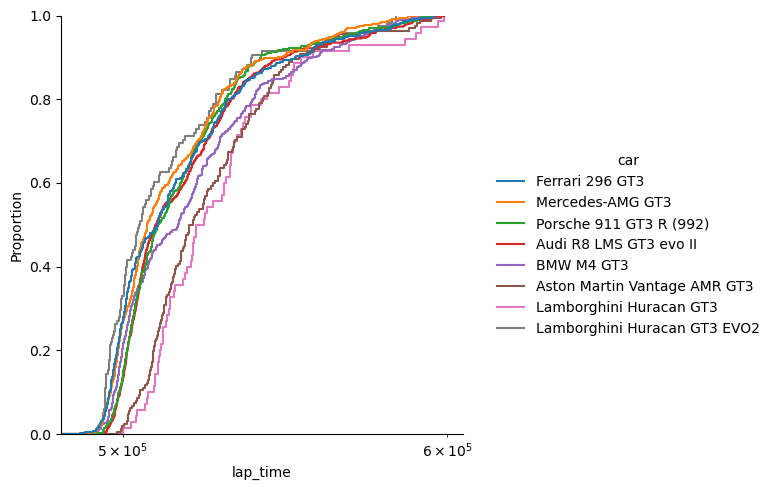

In [16]:
df_sp9_sectors = pd.DataFrame(df_race_sectors.query("class_short == 'SP 9' and in_pit == ['N']"))

#sns.histplot(df_sp9_sectors, x="lap_time", hue="car", kde=False, log_scale=(True, False))
sns.displot(df_sp9_sectors.query("lap_time < 600000"), x="lap_time", hue="car", log_scale=(True, False), kind="ecdf")
#df_sp9_sectors


<Axes: xlabel='lap_time', ylabel='car'>

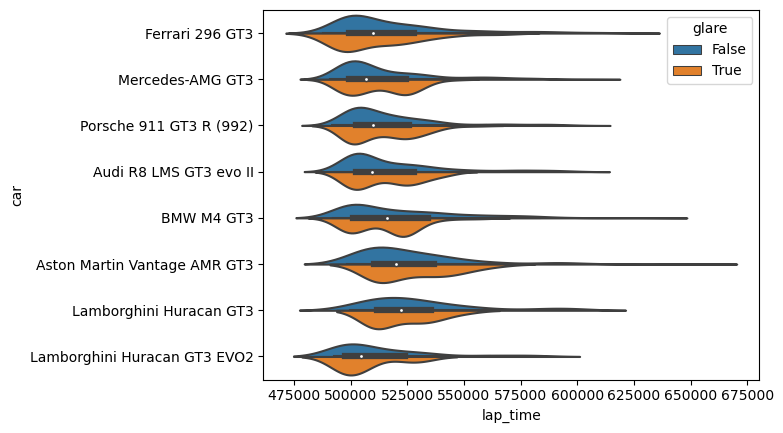

In [319]:
sns.violinplot(data=df_sp9_sectors, y="car", x="lap_time", hue="glare", split=True, showfliers=False)

<Axes: xlabel='lap_time', ylabel='car'>

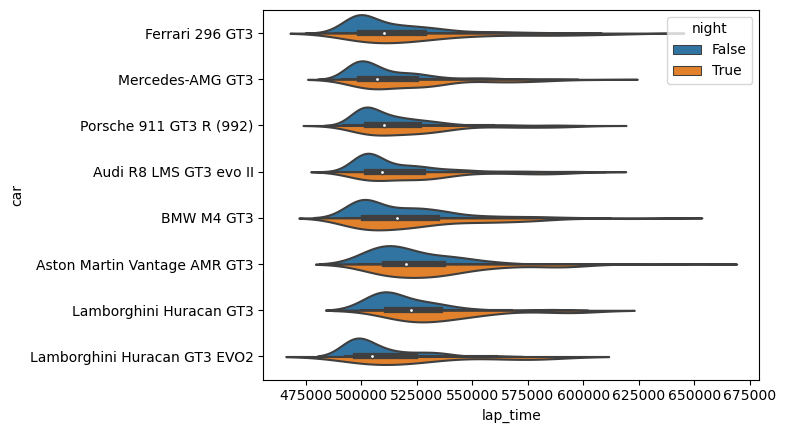

In [318]:
sns.violinplot(data=df_sp9_sectors, y="car", x="lap_time", hue="night", split=True, showfliers=False)
# sns.boxplot(data=df_sp9_sectors, y="car", x="lap_time", hue="night", showfliers=False)

In [333]:
sns.lineplot(
    data=df_sp9_sectors.set_index("lap_timestamp").rolling("10min")[f"lap_time"].mean(),
    hue="car"
    # x=df_sp9_sectors["lap_timestamp"],
    # y=df_sp9_sectors.rolling("10min")[f"lap_time"].mean(),
)

ValueError: The following variable cannot be assigned with wide-form data: `hue`

<Axes: xlabel='elapsed_time', ylabel='air_pressure'>

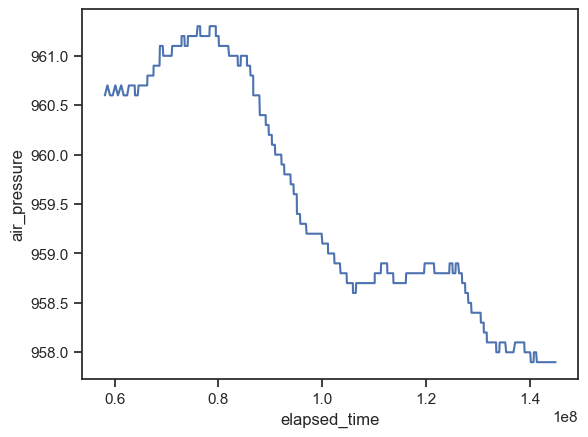

In [ ]:
df = df_race_sectors.query("class_short == 'SP 9' and in_pit == ['N']")
sns.lineplot(data=df, x="elapsed_time", y="air_pressure")

<Axes: xlabel='elapsed_time', ylabel='air_temperature'>

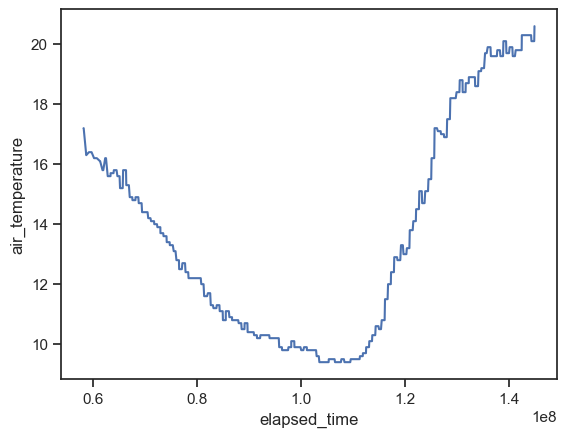

In [ ]:
df = df_race_sectors.query("class_short == 'SP 9' and in_pit == ['N']")
sns.lineplot(data=df, x="elapsed_time", y="air_temperature")

In [256]:
df = df_sp9_sectors.set_index("lap_timestamp")
# df = df_sp9_sectors.dropna()

# sns.lineplot(
#     data=df.rolling(30)["lap_time"].mean(),
# )

for secnum in range(1, 10):
    sns.lineplot(
        data=df.rolling("10min")[f"sector{secnum}_time"].mean(),
    )

sns.lineplot(
    data=df.rolling("10min")["lap_time"].mean(),
)

KeyError: "None of ['lap_timestamp'] are in the columns"

<Axes: xlabel='lap_timestamp', ylabel='sector7_time'>

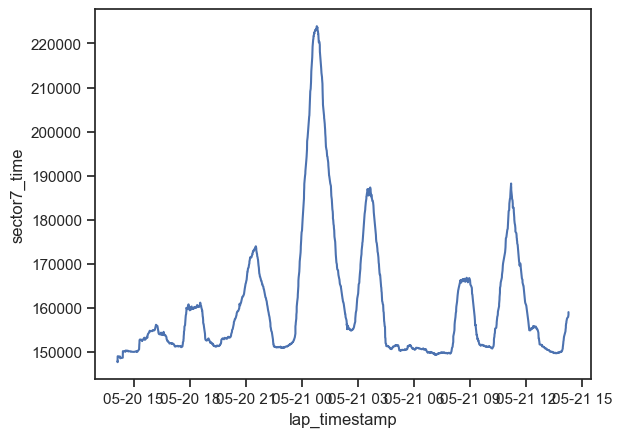

In [ ]:
sns.lineplot(
    data=df.rolling("60min")[f"sector7_time"].mean(),
)

In [76]:
df = df_long_sectors.dropna(subset="sector_timestamp").reset_index()
# df = df.set_index("sector_timestamp")


sns.lineplot(
    data=df.rolling(10)["sector_time"].mean(),
    # x="sector_timestamp",
    hue="sector",
)

df.rolling(10)["sector_time"].mean()

ValueError: The following variable cannot be assigned with wide-form data: `hue`

In [498]:
from itertools import chain

def get_sector_times(df: pd.DataFrame) -> pd.DataFrame:
    columns =  [[f"sectortime_{i}"] for i in range(1, 10)]
    columns = [*columns, ["lap_time"]]
    columns = list(chain.from_iterable(columns))
    dfst = df.loc[:,columns]
    dfst.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) for c in dfst.columns])
    return dfst


def plot_sector_time(sector) -> None:
    df = df_sp9_sectors.dropna(subset=[f"sector{sector}_timestamp", f"sector{sector}_time"]).sort_values(f"sector{sector}_timestamp").set_index(f"sector{sector}_timestamp")
    
    # df = df_sp9_sectors.set_index(f"elapsed_time")
    # df = df_sp9_sectors.dropna()

    # sns.lineplot(
    #     data=df.rolling("10min")[f"sector{sector}_time"].mean(),
    # )
    
    sns.lineplot(
        data=df.rolling("10min")[f"sector{sector}_time"].mean(),
    )

for i in range(1, 9):
    plot_sector_time(i)

# sns.lineplot(
#     data=df.rolling("10min")[f"lap_time"].mean(),
# )

# df_sp9_sectors
# get_sector_times(df_sp9_sectors).dropna().loc[:, "lap"]

KeyError: ['sector1_timestamp', 'sector1_time']

In [504]:
df = get_sector_times(df_clean_laps).melt().query("variable_0 == 'sectortime'")
df
# df.rolling("10min").groupby("variable_0")["value"].mean()
# sns.lineplot(
#     data=df.rolling("10min").group_by[f"sector{sector}_time"].mean(),
# )

[['sectortime_1'], ['sectortime_2'], ['sectortime_3'], ['sectortime_4'], ['sectortime_5'], ['sectortime_6'], ['sectortime_7'], ['sectortime_8'], ['sectortime_9']]
[['sectortime_1'], ['sectortime_2'], ['sectortime_3'], ['sectortime_4'], ['sectortime_5'], ['sectortime_6'], ['sectortime_7'], ['sectortime_8'], ['sectortime_9'], ['lap_time']]
['sectortime_1', 'sectortime_2', 'sectortime_3', 'sectortime_4', 'sectortime_5', 'sectortime_6', 'sectortime_7', 'sectortime_8', 'sectortime_9', 'lap_time']


,variable_0,variable_1,value
0,sectortime,1,48696.0
1,sectortime,1,40219.0
2,sectortime,1,40910.0
3,sectortime,1,40824.0
4,sectortime,1,40509.0
...,...,...,...
10876,sectortime,9,28503.0
10877,sectortime,9,28577.0
10878,sectortime,9,28742.0
10879,sectortime,9,28511.0


<Axes: xlabel='lap_timestamp', ylabel='air_temperature'>

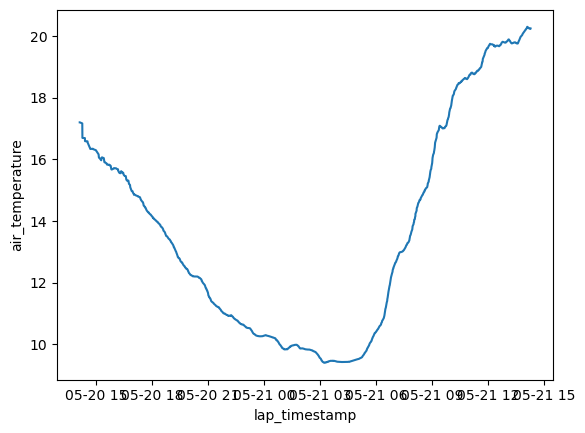

In [ ]:
df = df_sp9_sectors.set_index("lap_timestamp")
df = df.rolling("30min")["air_temperature"].mean()
sns.lineplot(
    data=df,
)

TODO: Lap time heatmap by car and time of day

<Axes: xlabel='air_pressure', ylabel='car'>

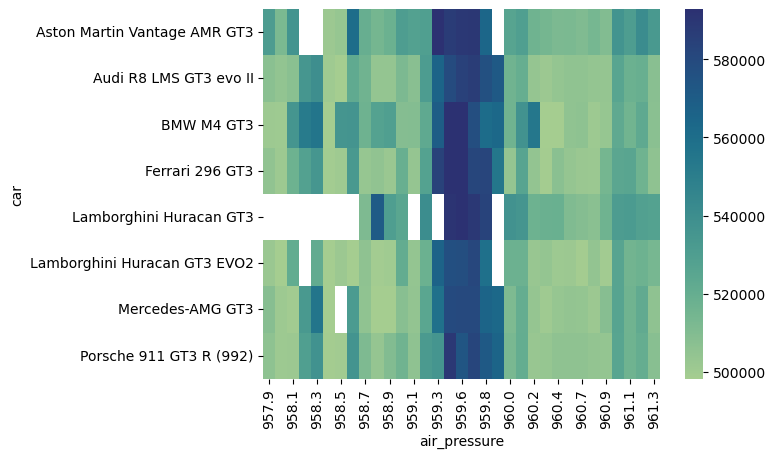

In [ ]:
df = pd.DataFrame(df_race_sectors.query("class_short == 'SP 9' and in_pit == ['N']")).pivot_table(index="car", columns="air_pressure", values="lap_time", aggfunc="median")


sns.heatmap(
    data=df, cmap="crest", robust=True)

In [25]:
def kmc(df: pd.DataFrame, column: str, group_name: str) -> pd.DataFrame:
    kmc = cluster.KMeans(n_clusters=3, n_init="auto")
    res = pd.DataFrame(df)
    
    cluster_indexes = kmc.fit_predict(res[[column]])
    
    # to obtain rank cluster centers, argsort() twice
    # see https://stackoverflow.com/a/6266510
    cluster_center_ranks = kmc.cluster_centers_.flatten().argsort().argsort()
    cluster_ranks = np.vectorize(cluster_center_ranks.take)(cluster_indexes)
    res[f"cluster_by_{group_name}"] = cluster_ranks
    return res

def gmc(df: pd.DataFrame, column: str, group_name: str) -> pd.DataFrame:
    gmc = mixture.GaussianMixture(n_components=4)
    res = pd.DataFrame(df)
    component_labels = gmc.fit_predict(res[[column]])
    component_mean_ranks = gmc.means_.flatten().argsort().argsort()
    component_ranks = np.vectorize(component_mean_ranks.take)(component_labels)
    res[f"cluster_by_{group_name}"] = component_ranks
    return res


df_clustered = df_sp9_sectors.groupby("car", group_keys=False).apply(gmc, "lap_time", "car_lap")
df_clustered

for secnum in range(1, 10):
    df_clustered = df_clustered.dropna(subset=[f"sector_time_{secnum}"]).groupby("car", group_keys=False).apply(gmc, f"sector_time_{secnum}", f"car_sector_{secnum}")
df_clustered

c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\p\miniconda3\envs\mbb-agp-sobe\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

,,team,car,elapsed_time,time_of_day,lap_time,class_short,sector_time_1,sector_is_best_time_1,sector_time_2,sector_is_best_time_2,...,cluster_by_car_lap,cluster_by_car_sector_1,cluster_by_car_sector_2,cluster_by_car_sector_3,cluster_by_car_sector_4,cluster_by_car_sector_5,cluster_by_car_sector_6,cluster_by_car_sector_7,cluster_by_car_sector_8,cluster_by_car_sector_9
car_number,lap_number,,,,,,,,,,,,,,,,,,,,,
30,1,Frikadelli Racing Team,Ferrari 296 GT3,58109943,16:08:29.943,505604,SP 9,47200.0,False,43513.0,False,...,0,2,0,0,0,0,0,0,0,0
3,1,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,58110437,16:08:30.437,506098,SP 9,47503.0,False,43783.0,False,...,0,2,1,0,0,0,0,0,0,0
44,1,Falken Motorsports,Porsche 911 GT3 R (992),58111046,16:08:31.046,506707,SP 9,47773.0,False,43892.0,False,...,0,1,1,0,0,0,0,0,0,0
5,1,Scherer Sport PHX,Audi R8 LMS GT3 evo II,58111434,16:08:31.434,507095,SP 9,48087.0,False,43744.0,False,...,0,1,1,0,0,0,0,0,0,0
2,1,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,58112566,16:08:32.566,508227,SP 9,48412.0,False,43623.0,False,...,1,2,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,160,Audi Sport Team Scherer PHX,Audi R8 LMS GT3 evo II,144728795,16:12:08.795,527198,SP 9,40700.0,False,43007.0,False,...,1,0,0,0,1,1,0,1,2,0
100,154,Walkenhorst Motorsport,BMW M4 GT3,144875338,16:14:35.338,527658,SP 9,40291.0,False,43029.0,False,...,1,0,0,1,1,0,2,1,2,1
96,162,Rutronik - Racing,Porsche 911 GT3 R (992),144891255,16:14:51.255,531363,SP 9,40671.0,False,43643.0,False,...,1,0,1,0,1,1,0,1,1,2


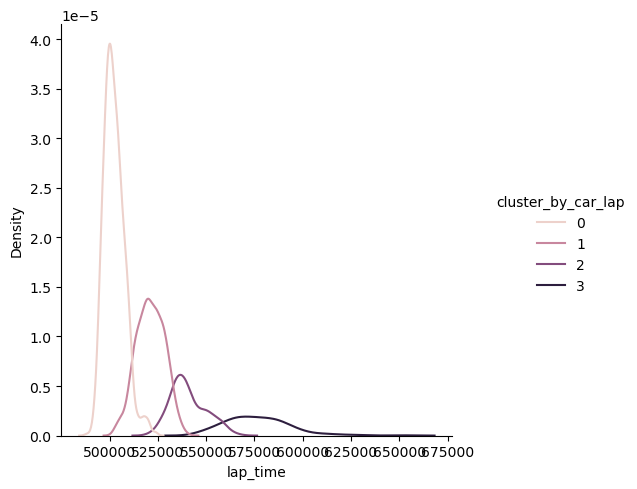

In [336]:
sns.displot(
    df_sp9_sectors,
    x="lap_time",
    hue="cluster_by_car_lap",
    kind="kde",
    log_scale=(False, False),
)

,,team,car,elapsed_time,time_of_day,lap_time,class_short,sector1_time,sector1_is_best_time,sector2_time,sector2_is_best_time,...,sector6_timestamp,sector5_timestamp,sector4_timestamp,sector3_timestamp,sector2_timestamp,sector1_timestamp,lap_time_class_q1,lap_time_class_q2,lap_time_class_q3,lap_time_class_outlier
car_number,lap_number,,,,,,,,,,,,,,,,,,,,,
30,1,Frikadelli Racing Team,Ferrari 296 GT3,58109943,16:08:29.943,505604,SP 9,47200.0,False,43513.0,False,...,2023-05-20 14:04:57.903000+00:00,2023-05-20 14:03:09.680000+00:00,2023-05-20 14:02:59.249000+00:00,2023-05-20 14:01:54.751000+00:00,2023-05-20 14:01:11.238000+00:00,2023-05-20 14:00:24.038000+00:00,501583.0,510952.0,528441.0,568728.0
3,1,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,58110437,16:08:30.437,506098,SP 9,47503.0,False,43783.0,False,...,2023-05-20 14:04:58.473000+00:00,2023-05-20 14:03:10.296000+00:00,2023-05-20 14:02:59.904000+00:00,2023-05-20 14:01:55.452000+00:00,2023-05-20 14:01:11.669000+00:00,2023-05-20 14:00:24.166000+00:00,501583.0,510952.0,528441.0,568728.0
44,1,Falken Motorsports,Porsche 911 GT3 R (992),58111046,16:08:31.046,506707,SP 9,47773.0,False,43892.0,False,...,2023-05-20 14:04:59.167000+00:00,2023-05-20 14:03:11.010000+00:00,2023-05-20 14:03:00.569000+00:00,2023-05-20 14:01:55.872000+00:00,2023-05-20 14:01:11.980000+00:00,2023-05-20 14:00:24.207000+00:00,501583.0,510952.0,528441.0,568728.0
5,1,Scherer Sport PHX,Audi R8 LMS GT3 evo II,58111434,16:08:31.434,507095,SP 9,48087.0,False,43744.0,False,...,2023-05-20 14:04:59.571000+00:00,2023-05-20 14:03:11.699000+00:00,2023-05-20 14:03:01.079000+00:00,2023-05-20 14:01:55.989000+00:00,2023-05-20 14:01:12.245000+00:00,2023-05-20 14:00:24.158000+00:00,501583.0,510952.0,528441.0,568728.0
2,1,Mercedes-AMG Team GetSpeed,Mercedes-AMG GT3,58112566,16:08:32.566,508227,SP 9,48412.0,False,43623.0,False,...,2023-05-20 14:05:00.337000+00:00,2023-05-20 14:03:12.126000+00:00,2023-05-20 14:03:01.559000+00:00,2023-05-20 14:01:56.175000+00:00,2023-05-20 14:01:12.552000+00:00,2023-05-20 14:00:24.140000+00:00,501583.0,510952.0,528441.0,568728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,148,PROsport-Racing,Aston Martin Vantage AMR GT4,144941408,16:15:41.408,657560,SP 10,46135.0,False,49371.0,False,...,2023-05-21 14:10:32.558000+00:00,2023-05-21 14:08:12.329000+00:00,2023-05-21 14:08:00.215000+00:00,2023-05-21 14:06:46.322000+00:00,2023-05-21 14:05:56.951000+00:00,2023-05-21 14:05:10.816000+00:00,549392.0,563686.0,585037.0,638504.5
28,158,PROsport-Racing,Aston Martin Vantage AMR GT3,144941425,16:15:41.425,651485,SP 9,41993.0,False,47806.0,False,...,2023-05-21 14:10:32.126000+00:00,2023-05-21 14:08:12.694000+00:00,2023-05-21 14:08:00.595000+00:00,2023-05-21 14:06:46.719000+00:00,2023-05-21 14:05:58.913000+00:00,2023-05-21 14:05:16.920000+00:00,501583.0,510952.0,528441.0,568728.0
76,143,Teichmann Racing,Toyota GR Supra GT4 EVO 2023,144972171,16:16:12.171,621634,SP 10,44927.0,False,49333.0,False,...,2023-05-21 14:11:22.746000+00:00,2023-05-21 14:09:16.673000+00:00,2023-05-21 14:09:05.255000+00:00,2023-05-21 14:07:53.047000+00:00,2023-05-21 14:07:03.714000+00:00,2023-05-21 14:06:18.787000+00:00,549392.0,563686.0,585037.0,638504.5


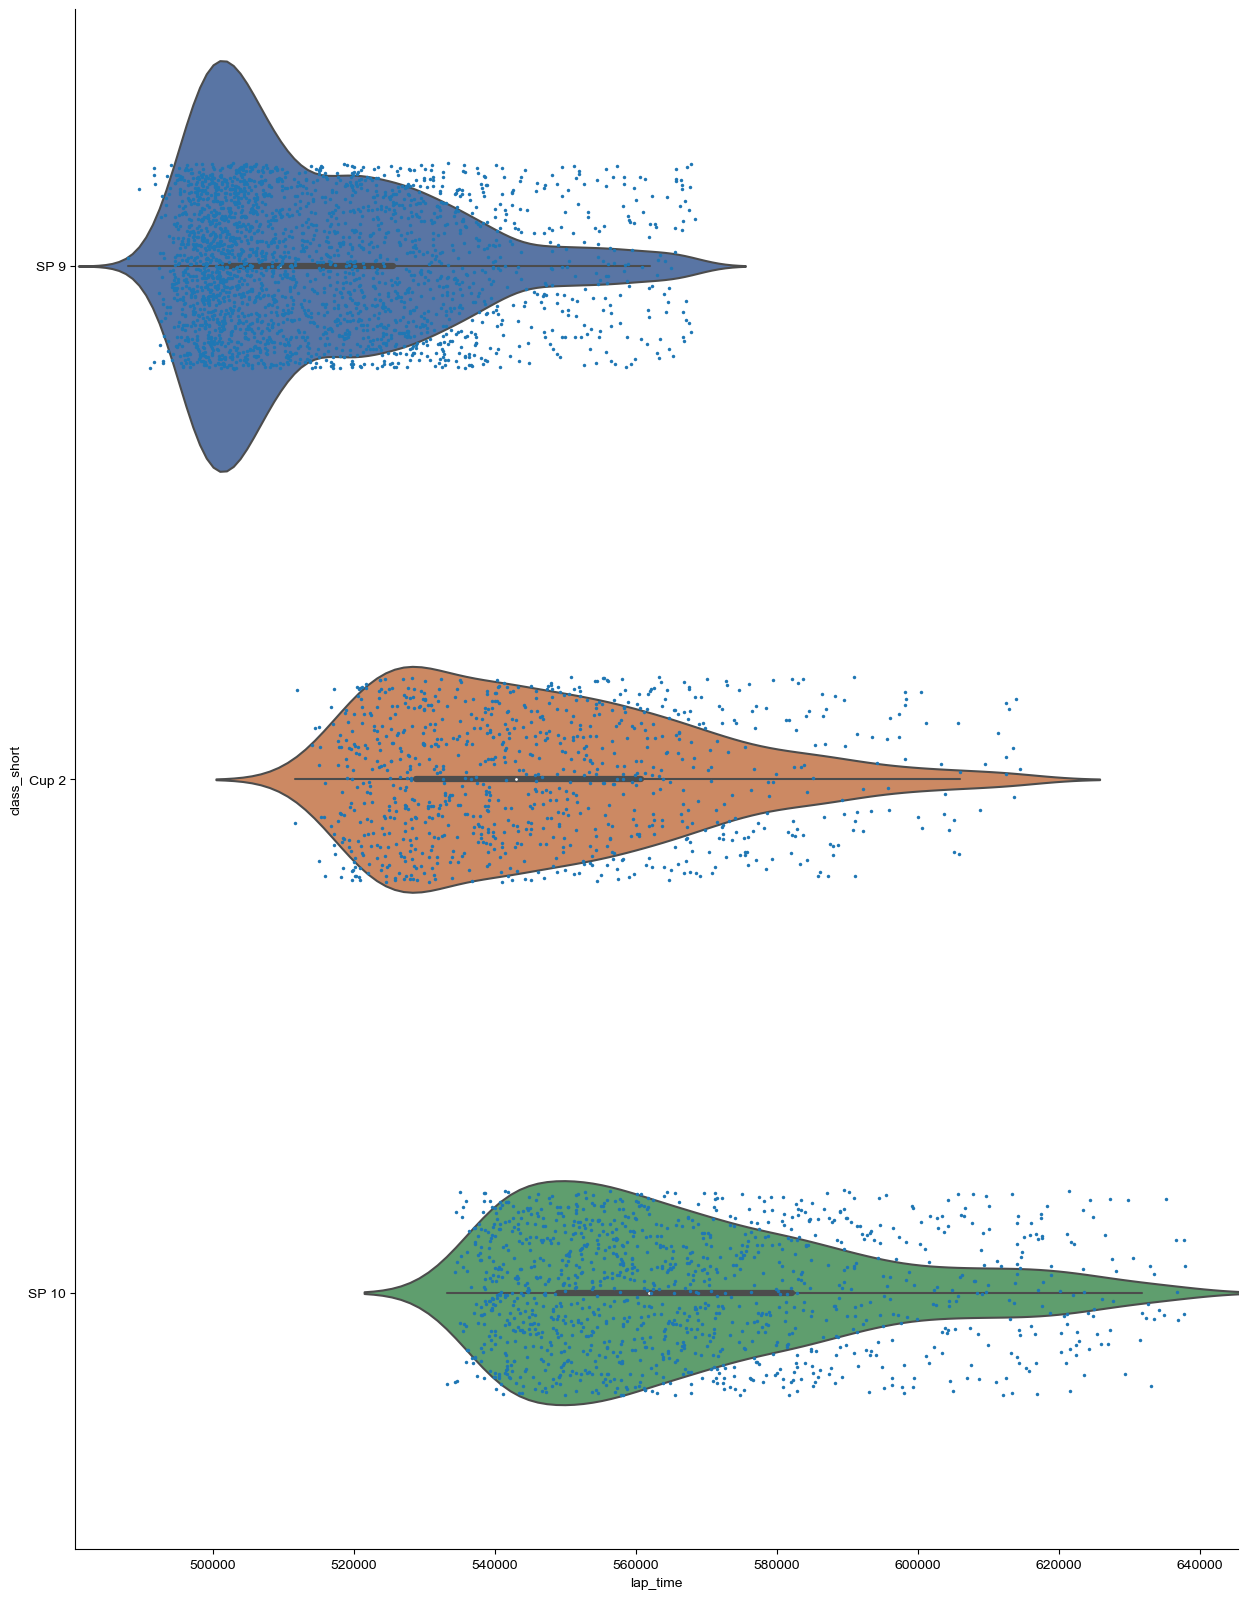

In [223]:
df_lapdist_by_class = pd.DataFrame(df_race_sectors.query("in_pit == 'N' and class_short == ['SP 9', 'SP 10', 'Cup 2']"))
# df_lapdist_by_class = pd.DataFrame(df_race_sectors.query("in_pit == 'N' and (pro == 0 and pro_am == 0)"))

df_lapdist_by_class["lap_time_class_q1"] = df_lapdist_by_class.groupby("class_short")[
    "lap_time"
].transform(np.quantile, q=0.25)
df_lapdist_by_class["lap_time_class_q2"] = df_lapdist_by_class.groupby("class_short")[
    "lap_time"
].transform(np.quantile, q=0.5)
df_lapdist_by_class["lap_time_class_q3"] = df_lapdist_by_class.groupby("class_short")[
    "lap_time"
].transform(np.quantile, q=0.75)
df_lapdist_by_class["lap_time_class_outlier"] = (
    df_lapdist_by_class["lap_time_class_q3"]
    + (
        df_lapdist_by_class["lap_time_class_q3"]
        - df_lapdist_by_class["lap_time_class_q1"]
    )
    * 1.5
)


f, ax = plt.subplots(figsize=(15, 20))
# ax.set_xscale("log")

df_lapdist_by_class_wo_outliers = df_lapdist_by_class.query(
    "lap_time < lap_time_class_outlier"
).sort_values(by="lap_time_class_q2")

sns.set(font="Inter")
sns.set_style("ticks")

sns.violinplot(
    y=df_lapdist_by_class_wo_outliers["class_short"],
    x=df_lapdist_by_class_wo_outliers["lap_time"],
)

sns.stripplot(
    y=df_lapdist_by_class_wo_outliers["class_short"],
    x=df_lapdist_by_class_wo_outliers["lap_time"],
    jitter=0.2,
    size=2.5,
)

sns.despine()

# df_lapdist_by_class.groupby("class_short")[["lap_time"]].quantile(q=0.75)


df_lapdist_by_class

team                           car  \
car_number lap_number                                                         
27         29                  ABT Sportsline  Lamborghini Huracan GT3 EVO2   
           90                  ABT Sportsline  Lamborghini Huracan GT3 EVO2   
           91                  ABT Sportsline  Lamborghini Huracan GT3 EVO2   
           9                   ABT Sportsline  Lamborghini Huracan GT3 EVO2   
           92                  ABT Sportsline  Lamborghini Huracan GT3 EVO2   
...                                       ...                           ...   
7          42          Konrad Motorsport GmbH       Lamborghini Huracan GT3   
           14          Konrad Motorsport GmbH       Lamborghini Huracan GT3   
           43          Konrad Motorsport GmbH       Lamborghini Huracan GT3   
           34          Konrad Motorsport GmbH       Lamborghini Huracan GT3   
           33          Konrad Motorsport GmbH       Lamborghini Huracan GT3   

                       elapsed_time   time_of_day  lap_time class_short  \
car_number lap_number                                                     
27         29              73663270  20:27:43.270    497131        SP 9   
           90             107349103  05:49:09.103    507447        SP 9   
           91             107854729  05:57:34.729    505626        SP 9   
           9               62281610  17:18:01.610    514419        SP 9   
           92             108354566  06:05:54.566    499837        SP 9   
...                             ...           ...       ...         ...   
7          42              80505126  22:21:45.126    524099        SP 9   
           14              64954368  18:02:34.368    506195        SP 9   
           43              81038096  22:30:38.096    532970        SP 9   
           34              76079806  21:07:59.806    531797        SP 9   
           33              75548009  20:59:08.009    534186        SP 9   

                       sector_time_1  sector_is_best_time_1  sector_time_2  \
car_number lap_number                                                        
27         29                39941.0                  False        42453.0   
           90                39765.0                  False        42375.0   
           91                40068.0                  False        42906.0   
           9                 40029.0                  False        42472.0   
           92                41183.0                  False        42326.0   
...                              ...                    ...            ...   
7          42                40362.0                  False        43017.0   
           14                40984.0                  False        43298.0   
           43                41395.0                  False        43112.0   
           34                40584.0                  False        43014.0   
           33                40536.0                  False        43762.0   

                       sector_is_best_time_2  ...  cluster_by_car_sector_4  \
car_number lap_number                         ...                            
27         29                          False  ...                        0   
           90                          False  ...                        0   
           91                          False  ...                        0   
           9                           False  ...                        0   
           92                          False  ...                        0   
...                                      ...  ...                      ...   
7          42                          False  ...                        0   
           14                          False  ...                        0   
           43                          False  ...                        0   
           34                          False  ...                        2   
           33                          False  ...                        2   

       

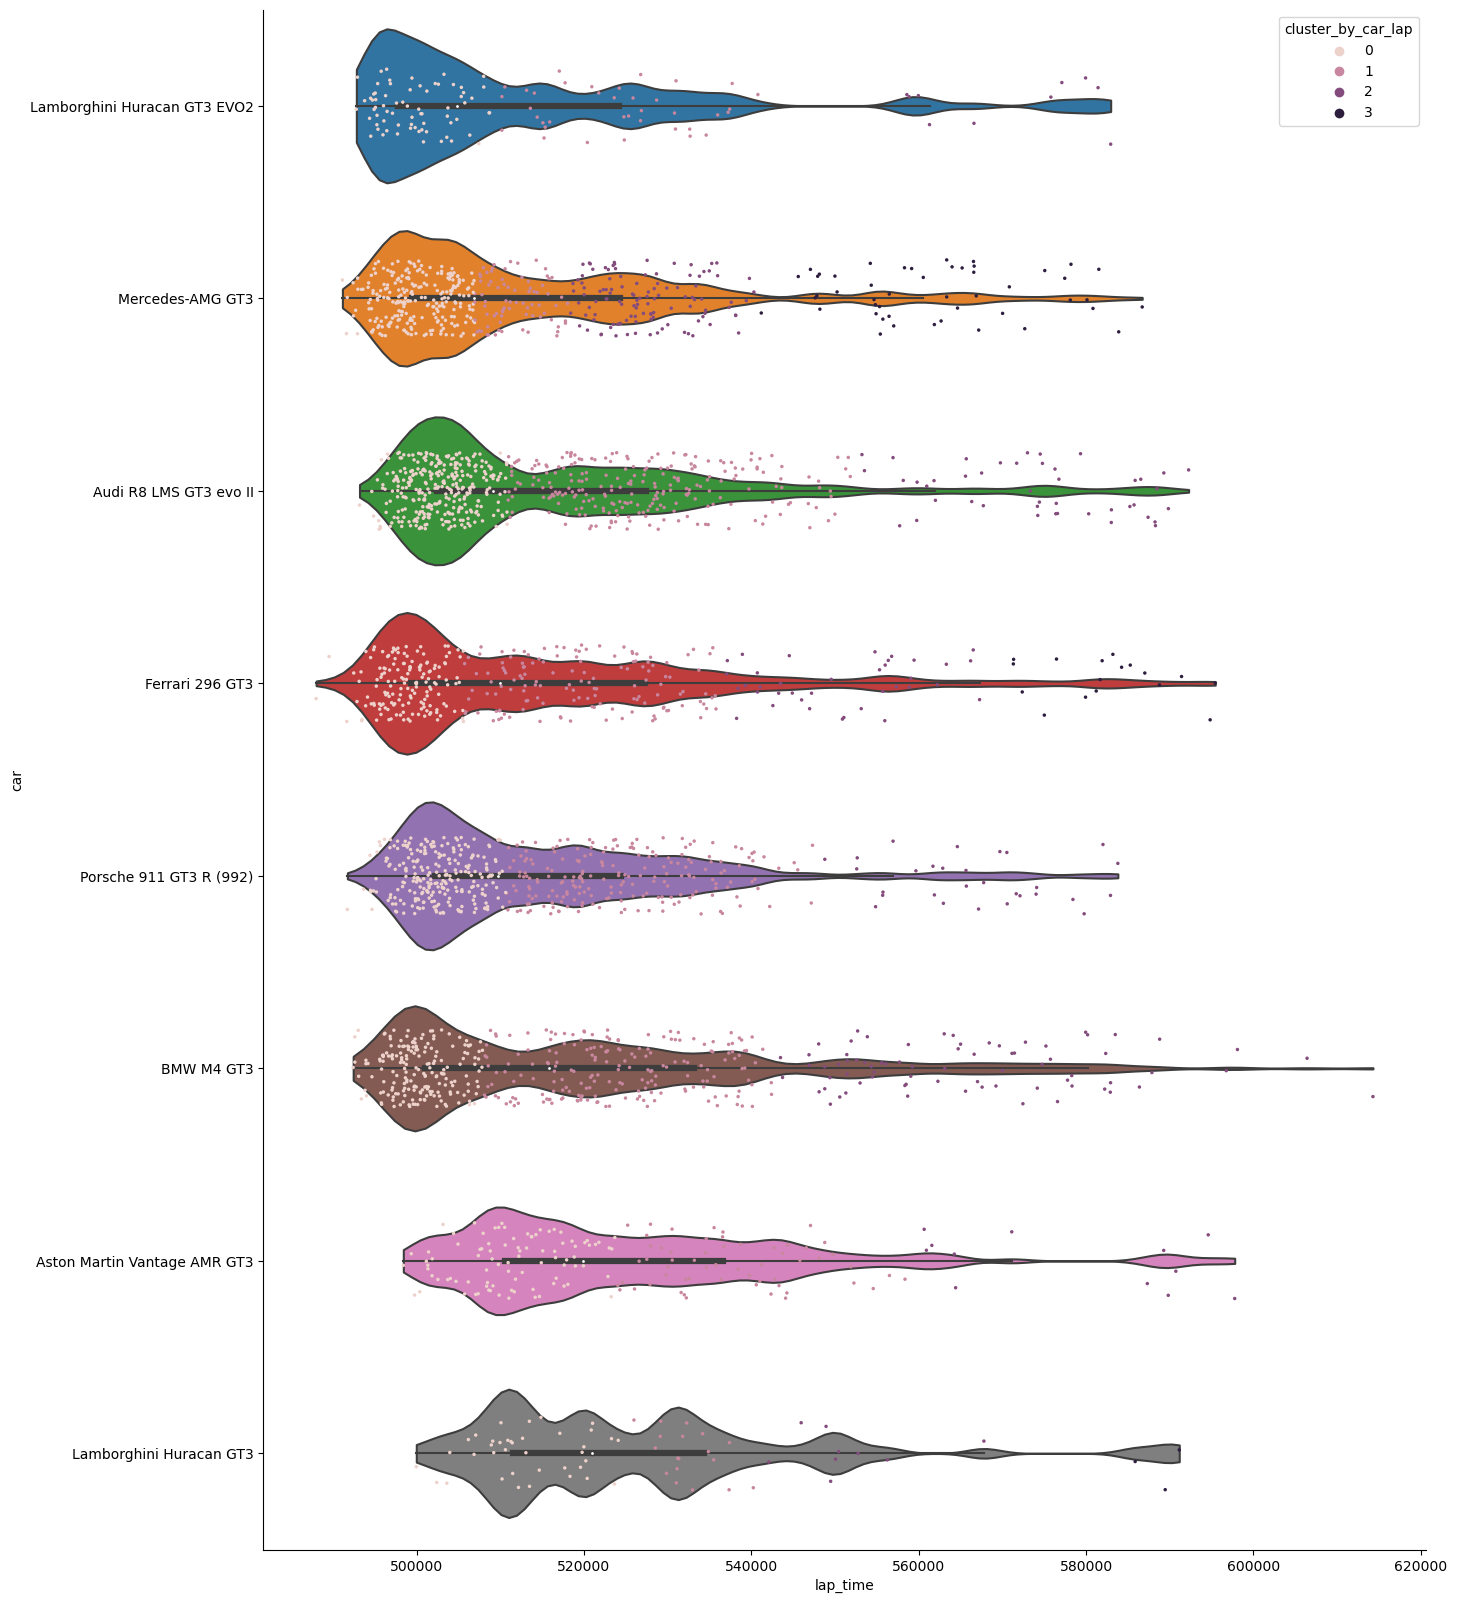

In [72]:
df_2023_24_gt3 =  pd.DataFrame(df_clustered)

df_2023_24_gt3["lap_time_car_q1"] = df_2023_24_gt3.groupby("car")[
    "lap_time"
].transform(np.quantile, q=0.25)
df_2023_24_gt3["lap_time_car_q2"] = df_2023_24_gt3.groupby("car")[
    "lap_time"
].transform(np.quantile, q=0.5)
df_2023_24_gt3["lap_time_car_q3"] = df_2023_24_gt3.groupby("car")[
    "lap_time"
].transform(np.quantile, q=0.75)

df_2023_24_gt3["lap_time_car_outlier"] = (
    df_2023_24_gt3["lap_time_car_q3"]
    + (
        df_2023_24_gt3["lap_time_car_q3"]
        - df_2023_24_gt3["lap_time_car_q1"]
    )
    * 2.5
)


f, ax = plt.subplots(figsize=(15, 20))
# ax.set_xscale("log")

df_2023_24_gt3_wo_outliers = df_2023_24_gt3.query(
    "lap_time < lap_time_car_outlier"
).sort_values(by="lap_time_car_q2")

sns.violinplot(
    y=df_2023_24_gt3_wo_outliers["car"],
    x=df_2023_24_gt3_wo_outliers["lap_time"],
    bw=.1,
    # bw_method="silverman",
    # width=1.5,
    cut=0
)

sns.stripplot(
    y=df_2023_24_gt3_wo_outliers["car"],
    x=df_2023_24_gt3_wo_outliers["lap_time"],
    jitter=0.2,
    size=2.5,
    hue=df_2023_24_gt3_wo_outliers["cluster_by_car_lap"]
)

sns.despine()

# df_lapdist_by_class.groupby("KLASSEKURZ")[["RUNDENZEIT"]].quantile(q=0.75)


df_2023_24_gt3_wo_outliers


Index(['Mercedes-AMG GT3', 'Lamborghini Huracan GT3 EVO2', 'Ferrari 296 GT3',
       'Porsche 911 GT3 R (992)', 'Audi R8 LMS GT3 evo II', 'BMW M4 GT3',
       'Aston Martin Vantage AMR GT3', 'Lamborghini Huracan GT3'],
      dtype='object', name='car')


,number,driver_number,team_name,car,lap_number,elapsed_time,time_of_day,lap_time,fastest,class,...,driver_license,lap_timestamp,azimuth,altitude,night,cluster_by_car,lap_time_car_q1,lap_time_car_q2,lap_time_car_q3,lap_time_car_outlier
1849,27,1,ABT Sportsline,Lamborghini Huracan GT3 EVO2,52,86239598,23:57:19.598,514082,N,SP 9,...,ITC-B03727,2023-05-20 21:57:19.598000+00:00,2.748968,-0.293105,True,1,497784.50,504815.0,524505.0,591306.250
1920,27,4,ABT Sportsline,Lamborghini Huracan GT3 EVO2,123,124805658,10:40:05.658,513153,N,SP 9,...,ITC-C02368,2023-05-21 08:40:05.658000+00:00,-1.106513,0.786499,False,1,497784.50,504815.0,524505.0,591306.250
1921,27,4,ABT Sportsline,Lamborghini Huracan GT3 EVO2,124,125311007,10:48:31.007,505349,N,SP 9,...,ITC-C02368,2023-05-21 08:48:31.007000+00:00,-1.067068,0.807267,False,0,497784.50,504815.0,524505.0,591306.250
1922,27,4,ABT Sportsline,Lamborghini Huracan GT3 EVO2,125,125805524,10:56:45.524,494517,N,SP 9,...,ITC-C02368,2023-05-21 08:56:45.524000+00:00,-1.027166,0.827152,False,0,497784.50,504815.0,524505.0,591306.250
1923,27,4,ABT Sportsline,Lamborghini Huracan GT3 EVO2,126,126320760,11:05:20.760,515236,N,SP 9,...,ITC-C02368,2023-05-21 09:05:20.760000+00:00,-0.984128,0.847356,False,1,497784.50,504815.0,524505.0,591306.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,7,2,Konrad Motorsport GmbH,Lamborghini Huracan GT3,43,81038096,22:30:38.096,532970,N,SP 9,...,ITC-A20308,2023-05-20 20:30:38.096000+00:00,2.408602,-0.164530,True,1,511665.25,522166.5,535351.5,594567.125
735,7,2,Konrad Motorsport GmbH,Lamborghini Huracan GT3,42,80505126,22:21:45.126,524099,N,SP 9,...,ITC-A20308,2023-05-20 20:21:45.126000+00:00,2.375895,-0.147708,True,1,511665.25,522166.5,535351.5,594567.125
734,7,2,Konrad Motorsport GmbH,Lamborghini Huracan GT3,41,79981027,22:13:01.027,552761,N,SP 9,...,ITC-A20308,2023-05-20 20:13:01.027000+00:00,2.344117,-0.130600,True,2,511665.25,522166.5,535351.5,594567.125
742,7,2,Konrad Motorsport GmbH,Lamborghini Huracan GT3,49,84467352,23:27:47.352,531220,N,SP 9,...,ITC-A20308,2023-05-20 21:27:47.352000+00:00,2.628770,-0.257208,True,1,511665.25,522166.5,535351.5,594567.125


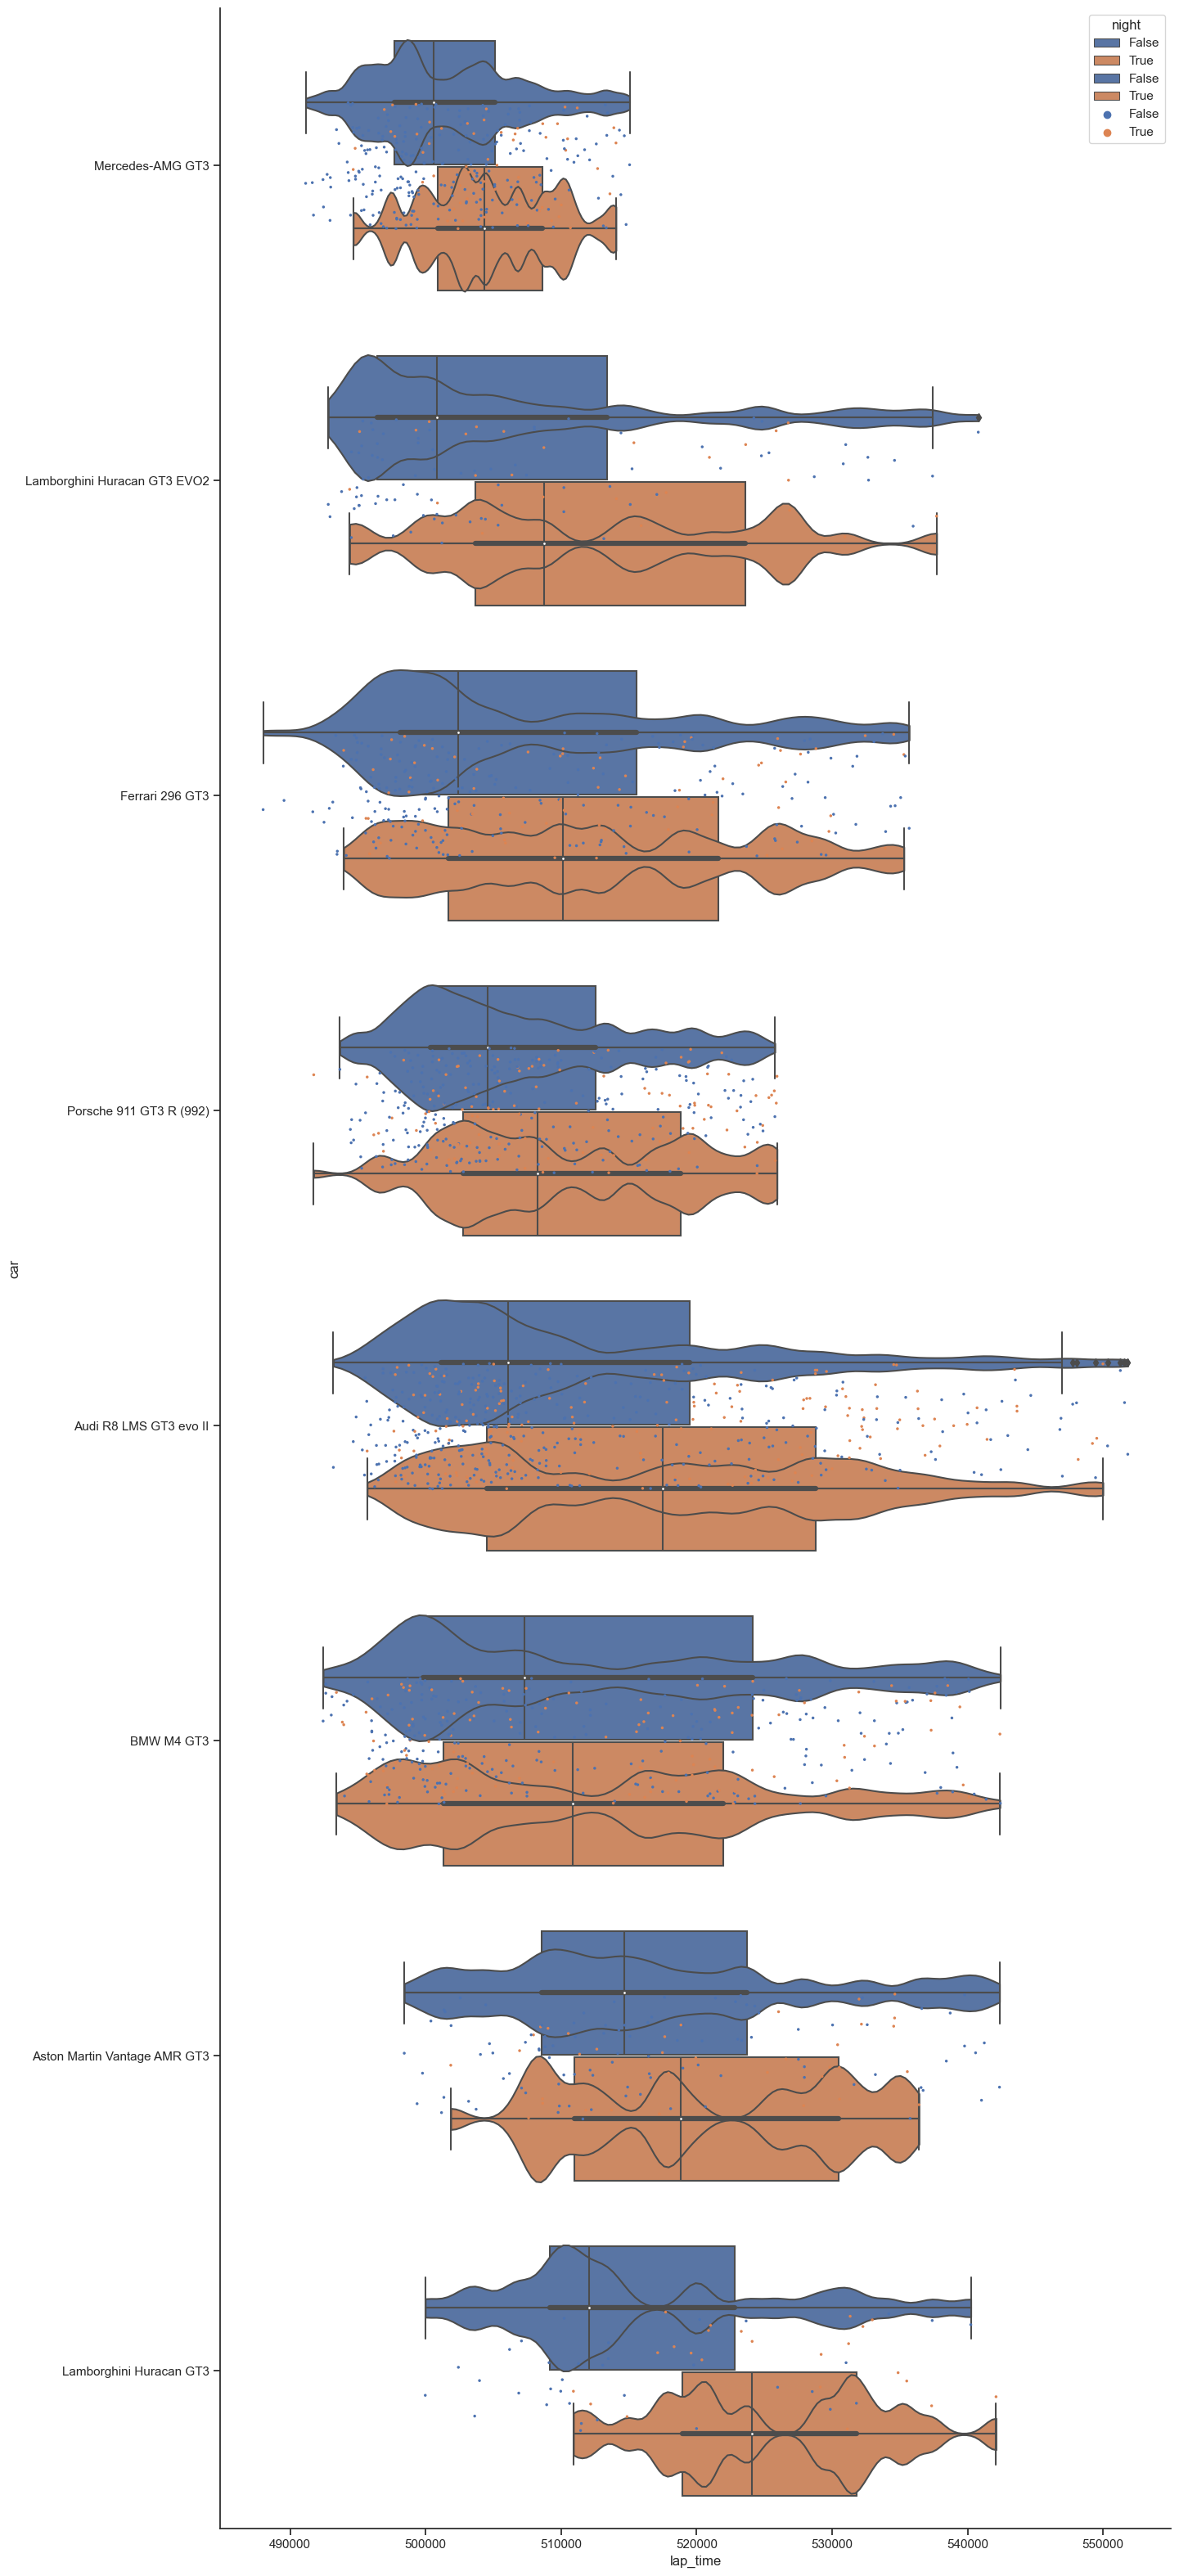

In [46]:
df_2023_24_gt3 =  pd.DataFrame(df_clustered).query("cluster_by_car == [0, 1]")

# df_2023_24_gt3["lap_time_car_median"] = df_2023_24_gt3.groupby("car")[
#     "lap_time"
# ].transform(np.quantile, q=0.5)

order = df_2023_24_gt3.groupby("car")["lap_time"].median().sort_values().index
print(order)

# df_2023_24_gt3.sort_values(by="lap_time_car_median", inplace=True)

f, ax = plt.subplots(figsize=(15, 40))
# ax.set_xscale("log")

sns.boxplot(
    data=df_2023_24_gt3,
    y="car",
    x="lap_time",
    hue="night",
    order=order
)

sns.violinplot(
    data=df_2023_24_gt3,
    y="car",
    x="lap_time",
    hue="night",
    bw=.1,
    cut=0,
    order=order
)


sns.stripplot(
    data=df_2023_24_gt3,
    y="car",
    x="lap_time",
    hue="night",
    jitter=0.2,
    size=2.5,
    order=order
)

sns.despine()

# df_lapdist_by_class.groupby("KLASSEKURZ")[["RUNDENZEIT"]].quantile(q=0.75)


df_2023_24_gt3_wo_outliers